In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, Callable, Union, Optional
from tensor_type import Tensor
from scipy.stats import norm, expon, uniform, multivariate_normal
from torch import mm, exp, log, det, minimum, sqrt, mul
from torch.linalg import inv, det

import time
import pdb

In [2]:
def KE(x:  Tensor,
       mu: Tensor,
       Minv: Optional[Tensor]=None,
       detM: Optional[float] =0.0) -> Tensor:
    '''
    This is a kinetic energy function KE(x) = -log pi(p|q), where
    pi is of general form xT.A.x
    x: is a point
    mu: is the distribution mean
    '''
    #pdb.set_trace()
    a = x-mu
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        ke = .5 * mm(a.t(), mm(Minv,a)) + const
    else:
        ke = .5 * mm(a.t(),a)
    return ke

def PE(x:  Tensor,
       mu: Tensor,
       Minv: Optional[Tensor] = None,
       detM: Optional[float] = 0.0) -> Tensor:
    '''
    -log pi(q) where pi(q) is Gaussian 
    '''
    #pdb.set_trace()
    a = x-mu
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        pe = .5 * mm(a.t(), mm(Minv,a)) + const
    else:
        pe = .5 * mm(a.t(),a)
    return pe

In [3]:
def get_autograd(func: Callable,
                 x:    Tensor,
                 mu:   Tensor,
                 Mat:  Tensor,
                 detMat: Optional[float] =0.0) -> Tuple[Tensor, Tensor]:
    '''
    dH calculates K(p) or V(q) along with associated gradient.
    x: is a tensor
    Mat: is a mass matrix
    func: is the K or V function to calculate
    returns function output and gradient
    '''
    #pdb.set_trace()
    x.requires_grad_(True) # track math operations
    x.retain_grad() # keep gradient after backward()
    out = func(x, mu, Mat, detMat)  # calculate given function
    out.backward(gradient=torch.ones(out.size()))  # Calculate grads
    x_grad = x.grad.data  # get gradients only
    x.grad = None  # reset gradient 
    x.requires_grad_(False)  # stop tracking
    return out.detach().clone(), x_grad 

# Unit Test
#t = torch.tensor([6., 4.]).view(2,1)
#tout, dt = dH(t, Minv, Tst2)

In [4]:
def stormer_verlet(V:    Callable,
                   q0:   Tensor,
                   p0:   Tensor,
                   mu:   Tensor,
                   Minv: Tensor,
                   eps:  float,
                   T:    int) -> Tuple[Tensor, Tensor]:
    '''
    Stormer-Verlet should propagate a point in phase space
    (p,q) according to Hamiltonian H.
    
    dVdq: references a function yielding the derivative of
    potential energy V.
    q0: is initial position tensor
    p0: is initial momentum tensor
    eps: scalar time increment
    T: time interval length
    returns numpy arrays q and p
    '''
    global qPath
    Nsteps = int(T//eps)
    q, p = q0.clone(), p0.clone()    
    for n in range(Nsteps):
        #pdb.set_trace()
        start = time.time()
        _, dHdq = get_autograd(V, q, mu, Minv, detM)
        d1 = time.time()-start
        
        p -= eps * dHdq/2 # half momentum step
        q += eps * p # full parameter step
        
        start = time.time()
        _, dHdq = get_autograd(V, q, mu, Minv, detM)
        d2 = time.time()-start
        p -= eps * dHdq # full momentum step
        
        qPath[n,:] = torch.squeeze(q)
        print(f'n={n}  derivative time {d1:.6f} --- {d2:.6f}')
        
    return q,-p 

In [5]:
def acceptance(q0: Tensor,
               p0: Tensor,
               q:  Tensor,
               p:  Tensor,
               mu: Tensor,
               Minv: Optional[Tensor]=None) -> Tuple[Tensor, bool]:
    '''
    This function calculates the acceptance ratio for a proposal point.
    as min(1, exp(deltaE)) and checks this against a random uniform observer
    value. 
    q,q0,p,p0: Tensors
    mu: Tensor
    Minv: Tensor
    Returns a point and a boolean flag denoting accept or not accept
    '''
    #pdb.set_trace()
    KE0, PE0       = KE(q0, mu, Minv, detM) , PE(p0, mu, Minv, detM) 
    KEstar, PEstar = KE(q, mu, Minv, detM)  , PE(p, mu, Minv, detM)
    ke_diff = exp((KE0 + PE0) - (KEstar + PEstar)).item()
    r = min(1., ke_diff)
    obs = uniform.rvs()
    if obs < r:
        point = q
        acceptFlag = True
    else:
        point = q0
        acceptFlag = False
    return point, acceptFlag

In [6]:
T = 5  # Full time-steps
eps = 0.2  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 2000  # Number of q's to test 
D = 2  # Dimension of q
M = torch.tensor([[1., 0.6],
                  [0.6, 1.]])
Minv = inv(M)
detM = det(M).type(torch.float32)
mu = torch.tensor([[0.],[0.]],dtype=torch.float32)

In [7]:
%%time
accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic
allPaths = qPath = torch.zeros((Nq, Nsteps, D))
pathFlag = []

# pre-select random q's
Q0 = np.random.uniform(low=-4, high=4, size=(D,Nq)) #(2,100)
# Loop iterations
for n in range(Nq):
    #print(f'Iter: {n}')
    qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    q0 = torch.from_numpy(Q0[:,n].reshape(2,1)).type(torch.float32)
    # sample momentum p0 from normal
    p0 = torch.from_numpy(norm.rvs(size = 2)).type(torch.float32).view(2,1)
    #print(p0.size())
    # q0,p0 are (2,1) tensors
    q, p = stormer_verlet(PE, q0, p0, mu, Minv, eps, T)
    q1, aFlag = acceptance(q0, p0, q, p, mu, Minv)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
    else:
        rejected +=1
    pathFlag.append(aFlag)
    allPaths[n,:,:] = qPath[:,:]
    
print(f'Acceptance rate: {accepted/Nq}\n\n')    

n=0  derivative time 0.113333 --- 0.000365
n=1  derivative time 0.000460 --- 0.000174
n=2  derivative time 0.000285 --- 0.000173
n=3  derivative time 0.000263 --- 0.000165
n=4  derivative time 0.000263 --- 0.000164
n=5  derivative time 0.000254 --- 0.000157
n=6  derivative time 0.000263 --- 0.000160
n=7  derivative time 0.000255 --- 0.000161
n=8  derivative time 0.000259 --- 0.000160
n=9  derivative time 0.000255 --- 0.000159
n=10  derivative time 0.000262 --- 0.000160
n=11  derivative time 0.000246 --- 0.000157
n=12  derivative time 0.000251 --- 0.000206
n=13  derivative time 0.000339 --- 0.000211
n=14  derivative time 0.000295 --- 0.000154
n=15  derivative time 0.000244 --- 0.000157
n=16  derivative time 0.000246 --- 0.000154
n=17  derivative time 0.000244 --- 0.000156
n=18  derivative time 0.000249 --- 0.000153
n=19  derivative time 0.000245 --- 0.000155
n=20  derivative time 0.000247 --- 0.000153
n=21  derivative time 0.000245 --- 0.000154
n=22  derivative time 0.000245 --- 0.00015

n=0  derivative time 0.000191 --- 0.000162
n=1  derivative time 0.000252 --- 0.000141
n=2  derivative time 0.000287 --- 0.000169
n=3  derivative time 0.000252 --- 0.000155
n=4  derivative time 0.000248 --- 0.000155
n=5  derivative time 0.000223 --- 0.000135
n=6  derivative time 0.000225 --- 0.000140
n=7  derivative time 0.000223 --- 0.000135
n=8  derivative time 0.000225 --- 0.000134
n=9  derivative time 0.000253 --- 0.000139
n=10  derivative time 0.000259 --- 0.000155
n=11  derivative time 0.000305 --- 0.000197
n=12  derivative time 0.000265 --- 0.000162
n=13  derivative time 0.000243 --- 0.000154
n=14  derivative time 0.000244 --- 0.000160
n=15  derivative time 0.000245 --- 0.000154
n=16  derivative time 0.000243 --- 0.000160
n=17  derivative time 0.000252 --- 0.000153
n=18  derivative time 0.000272 --- 0.000164
n=19  derivative time 0.000251 --- 0.000155
n=20  derivative time 0.000247 --- 0.000161
n=21  derivative time 0.000247 --- 0.000154
n=22  derivative time 0.000245 --- 0.00016

n=1  derivative time 0.000875 --- 0.000165
n=2  derivative time 0.000343 --- 0.000156
n=3  derivative time 0.000262 --- 0.000147
n=4  derivative time 0.000307 --- 0.000215
n=5  derivative time 0.000301 --- 0.000205
n=6  derivative time 0.000296 --- 0.000152
n=7  derivative time 0.000244 --- 0.000162
n=8  derivative time 0.000246 --- 0.000152
n=9  derivative time 0.000271 --- 0.000166
n=10  derivative time 0.000241 --- 0.000153
n=11  derivative time 0.000242 --- 0.000162
n=12  derivative time 0.000245 --- 0.000151
n=13  derivative time 0.000244 --- 0.000162
n=14  derivative time 0.000252 --- 0.000151
n=15  derivative time 0.000240 --- 0.000161
n=16  derivative time 0.000240 --- 0.000151
n=17  derivative time 0.000240 --- 0.000195
n=18  derivative time 0.000291 --- 0.000197
n=19  derivative time 0.000294 --- 0.000178
n=20  derivative time 0.000247 --- 0.000152
n=21  derivative time 0.000253 --- 0.000152
n=22  derivative time 0.000242 --- 0.000152
n=23  derivative time 0.000286 --- 0.0001

n=19  derivative time 0.000603 --- 0.000167
n=20  derivative time 0.000296 --- 0.000154
n=21  derivative time 0.000247 --- 0.000157
n=22  derivative time 0.000299 --- 0.000154
n=23  derivative time 0.000312 --- 0.000198
n=0  derivative time 0.000200 --- 0.000163
n=1  derivative time 0.000258 --- 0.000157
n=2  derivative time 0.000257 --- 0.000155
n=3  derivative time 0.000243 --- 0.000154
n=4  derivative time 0.000251 --- 0.000154
n=5  derivative time 0.000244 --- 0.000152
n=6  derivative time 0.000250 --- 0.000153
n=7  derivative time 0.000243 --- 0.000153
n=8  derivative time 0.000255 --- 0.000153
n=9  derivative time 0.000275 --- 0.000155
n=10  derivative time 0.000252 --- 0.000153
n=11  derivative time 0.000243 --- 0.000154
n=12  derivative time 0.000252 --- 0.000153
n=13  derivative time 0.000244 --- 0.000154
n=14  derivative time 0.000250 --- 0.000153
n=15  derivative time 0.000241 --- 0.000153
n=16  derivative time 0.000249 --- 0.000153
n=17  derivative time 0.000242 --- 0.00015

n=12  derivative time 0.000701 --- 0.000206
n=13  derivative time 0.000335 --- 0.000195
n=14  derivative time 0.000269 --- 0.000206
n=15  derivative time 0.000302 --- 0.000207
n=16  derivative time 0.000293 --- 0.000182
n=17  derivative time 0.000256 --- 0.000175
n=18  derivative time 0.000250 --- 0.000155
n=19  derivative time 0.000268 --- 0.000154
n=20  derivative time 0.000245 --- 0.000154
n=21  derivative time 0.000253 --- 0.000153
n=22  derivative time 0.000240 --- 0.000153
n=23  derivative time 0.000248 --- 0.000154
n=0  derivative time 0.000201 --- 0.000160
n=1  derivative time 0.000266 --- 0.000156
n=2  derivative time 0.000264 --- 0.000156
n=3  derivative time 0.000258 --- 0.000153
n=4  derivative time 0.000301 --- 0.000196
n=5  derivative time 0.000295 --- 0.000206
n=6  derivative time 0.000255 --- 0.000153
n=7  derivative time 0.000259 --- 0.000154
n=8  derivative time 0.000301 --- 0.000193
n=9  derivative time 0.000336 --- 0.000199
n=10  derivative time 0.000293 --- 0.00020

n=1  derivative time 0.000620 --- 0.000226
n=2  derivative time 0.000340 --- 0.000196
n=3  derivative time 0.000318 --- 0.000206
n=4  derivative time 0.000290 --- 0.000206
n=5  derivative time 0.000255 --- 0.000152
n=6  derivative time 0.000245 --- 0.000155
n=7  derivative time 0.000243 --- 0.000151
n=8  derivative time 0.000242 --- 0.000160
n=9  derivative time 0.000273 --- 0.000156
n=10  derivative time 0.000244 --- 0.000157
n=11  derivative time 0.000241 --- 0.000152
n=12  derivative time 0.000245 --- 0.000163
n=13  derivative time 0.000251 --- 0.000151
n=14  derivative time 0.000242 --- 0.000170
n=15  derivative time 0.000227 --- 0.000132
n=16  derivative time 0.000221 --- 0.000140
n=17  derivative time 0.000234 --- 0.000133
n=18  derivative time 0.000230 --- 0.000135
n=19  derivative time 0.000249 --- 0.000153
n=20  derivative time 0.000244 --- 0.000205
n=21  derivative time 0.000293 --- 0.000196
n=22  derivative time 0.000301 --- 0.000155
n=23  derivative time 0.000265 --- 0.0001

n=12  derivative time 0.000760 --- 0.000158
n=13  derivative time 0.000176 --- 0.000152
n=14  derivative time 0.000328 --- 0.000196
n=15  derivative time 0.000334 --- 0.000202
n=16  derivative time 0.000304 --- 0.000196
n=17  derivative time 0.000331 --- 0.000199
n=18  derivative time 0.000303 --- 0.000205
n=19  derivative time 0.000298 --- 0.000196
n=20  derivative time 0.000304 --- 0.000196
n=21  derivative time 0.000297 --- 0.000194
n=22  derivative time 0.000298 --- 0.000196
n=23  derivative time 0.000295 --- 0.000205
n=0  derivative time 0.000249 --- 0.000204
n=1  derivative time 0.000310 --- 0.000211
n=2  derivative time 0.000300 --- 0.000196
n=3  derivative time 0.000307 --- 0.000196
n=4  derivative time 0.000299 --- 0.000197
n=5  derivative time 0.000297 --- 0.000195
n=6  derivative time 0.000263 --- 0.000163
n=7  derivative time 0.000253 --- 0.000152
n=8  derivative time 0.000257 --- 0.000248
n=9  derivative time 0.000299 --- 0.000197
n=10  derivative time 0.000303 --- 0.00019

n=21  derivative time 0.000744 --- 0.000198
n=22  derivative time 0.000345 --- 0.000205
n=23  derivative time 0.000278 --- 0.000193
n=0  derivative time 0.000237 --- 0.000205
n=1  derivative time 0.000290 --- 0.000200
n=2  derivative time 0.000239 --- 0.000163
n=3  derivative time 0.000225 --- 0.000153
n=4  derivative time 0.000224 --- 0.000161
n=5  derivative time 0.000224 --- 0.000152
n=6  derivative time 0.000221 --- 0.000151
n=7  derivative time 0.000222 --- 0.000152
n=8  derivative time 0.000221 --- 0.000174
n=9  derivative time 0.000268 --- 0.000196
n=10  derivative time 0.000276 --- 0.000207
n=11  derivative time 0.000278 --- 0.000197
n=12  derivative time 0.000283 --- 0.000171
n=13  derivative time 0.000220 --- 0.000153
n=14  derivative time 0.000227 --- 0.000154
n=15  derivative time 0.000220 --- 0.000151
n=16  derivative time 0.000290 --- 0.000192
n=17  derivative time 0.000245 --- 0.000156
n=18  derivative time 0.000228 --- 0.000154
n=19  derivative time 0.000221 --- 0.00015

n=12  derivative time 0.000705 --- 0.000198
n=13  derivative time 0.000268 --- 0.000197
n=14  derivative time 0.000279 --- 0.000201
n=15  derivative time 0.000286 --- 0.000194
n=16  derivative time 0.000276 --- 0.000197
n=17  derivative time 0.000303 --- 0.000196
n=18  derivative time 0.000285 --- 0.000196
n=19  derivative time 0.000276 --- 0.000196
n=20  derivative time 0.000278 --- 0.000194
n=21  derivative time 0.000276 --- 0.000202
n=22  derivative time 0.000275 --- 0.000193
n=23  derivative time 0.000282 --- 0.000194
n=0  derivative time 0.000236 --- 0.000205
n=1  derivative time 0.000287 --- 0.000203
n=2  derivative time 0.000278 --- 0.000196
n=3  derivative time 0.000291 --- 0.000196
n=4  derivative time 0.000276 --- 0.000203
n=5  derivative time 0.000276 --- 0.000194
n=6  derivative time 0.000276 --- 0.000201
n=7  derivative time 0.000274 --- 0.000194
n=8  derivative time 0.000282 --- 0.000195
n=9  derivative time 0.000281 --- 0.000195
n=10  derivative time 0.000278 --- 0.00019

n=2  derivative time 0.000714 --- 0.000209
n=3  derivative time 0.000335 --- 0.000196
n=4  derivative time 0.000223 --- 0.000196
n=5  derivative time 0.000286 --- 0.000201
n=6  derivative time 0.000280 --- 0.000194
n=7  derivative time 0.000278 --- 0.000204
n=8  derivative time 0.000276 --- 0.000227
n=9  derivative time 0.000288 --- 0.000196
n=10  derivative time 0.000276 --- 0.000196
n=11  derivative time 0.000278 --- 0.000195
n=12  derivative time 0.000276 --- 0.000206
n=13  derivative time 0.000275 --- 0.000194
n=14  derivative time 0.000285 --- 0.000196
n=15  derivative time 0.000274 --- 0.000193
n=16  derivative time 0.000276 --- 0.000193
n=17  derivative time 0.000304 --- 0.000207
n=18  derivative time 0.000275 --- 0.000195
n=19  derivative time 0.000286 --- 0.000195
n=20  derivative time 0.000272 --- 0.000192
n=21  derivative time 0.000282 --- 0.000193
n=22  derivative time 0.000273 --- 0.000201
n=23  derivative time 0.000274 --- 0.000193
n=0  derivative time 0.000235 --- 0.0002

n=0  derivative time 0.000235 --- 0.000203
n=1  derivative time 0.000337 --- 0.000196
n=2  derivative time 0.000281 --- 0.000196
n=3  derivative time 0.000284 --- 0.000196
n=4  derivative time 0.000277 --- 0.000207
n=5  derivative time 0.000225 --- 0.000153
n=6  derivative time 0.000222 --- 0.000161
n=7  derivative time 0.000221 --- 0.000151
n=8  derivative time 0.000222 --- 0.000197
n=9  derivative time 0.000225 --- 0.000153
n=10  derivative time 0.000223 --- 0.000159
n=11  derivative time 0.000223 --- 0.000152
n=12  derivative time 0.000221 --- 0.000150
n=13  derivative time 0.000223 --- 0.000151
n=14  derivative time 0.000222 --- 0.000151
n=15  derivative time 0.000230 --- 0.000151
n=16  derivative time 0.000221 --- 0.000150
n=17  derivative time 0.000254 --- 0.000157
n=18  derivative time 0.000222 --- 0.000152
n=19  derivative time 0.000229 --- 0.000154
n=20  derivative time 0.000221 --- 0.000151
n=21  derivative time 0.000221 --- 0.000154
n=22  derivative time 0.000222 --- 0.00015

n=19  derivative time 0.000600 --- 0.000212
n=20  derivative time 0.000334 --- 0.000196
n=21  derivative time 0.000274 --- 0.000182
n=22  derivative time 0.000276 --- 0.000194
n=23  derivative time 0.000276 --- 0.000203
n=0  derivative time 0.000187 --- 0.000163
n=1  derivative time 0.000232 --- 0.000156
n=2  derivative time 0.000225 --- 0.000157
n=3  derivative time 0.000223 --- 0.000153
n=4  derivative time 0.000222 --- 0.000160
n=5  derivative time 0.000222 --- 0.000151
n=6  derivative time 0.000221 --- 0.000160
n=7  derivative time 0.000221 --- 0.000152
n=8  derivative time 0.000222 --- 0.000185
n=9  derivative time 0.000226 --- 0.000154
n=10  derivative time 0.000222 --- 0.000153
n=11  derivative time 0.000252 --- 0.000195
n=12  derivative time 0.000274 --- 0.000203
n=13  derivative time 0.000222 --- 0.000153
n=14  derivative time 0.000221 --- 0.000159
n=15  derivative time 0.000222 --- 0.000151
n=16  derivative time 0.000222 --- 0.000160
n=17  derivative time 0.000250 --- 0.00015

n=1  derivative time 0.000618 --- 0.000211
n=2  derivative time 0.000346 --- 0.000155
n=3  derivative time 0.000231 --- 0.000152
n=4  derivative time 0.000244 --- 0.000195
n=5  derivative time 0.000274 --- 0.000201
n=6  derivative time 0.000225 --- 0.000152
n=7  derivative time 0.000223 --- 0.000133
n=8  derivative time 0.000201 --- 0.000158
n=9  derivative time 0.000203 --- 0.000135
n=10  derivative time 0.000207 --- 0.000134
n=11  derivative time 0.000199 --- 0.000134
n=12  derivative time 0.000220 --- 0.000159
n=13  derivative time 0.000221 --- 0.000152
n=14  derivative time 0.000224 --- 0.000164
n=15  derivative time 0.000223 --- 0.000150
n=16  derivative time 0.000221 --- 0.000150
n=17  derivative time 0.000248 --- 0.000154
n=18  derivative time 0.000223 --- 0.000152
n=19  derivative time 0.000232 --- 0.000134
n=20  derivative time 0.000202 --- 0.000133
n=21  derivative time 0.000206 --- 0.000134
n=22  derivative time 0.000199 --- 0.000132
n=23  derivative time 0.000200 --- 0.0001

n=16  derivative time 0.000698 --- 0.000198
n=17  derivative time 0.000369 --- 0.000199
n=18  derivative time 0.000253 --- 0.000214
n=19  derivative time 0.000276 --- 0.000195
n=20  derivative time 0.000284 --- 0.000196
n=21  derivative time 0.000257 --- 0.000152
n=22  derivative time 0.000227 --- 0.000153
n=23  derivative time 0.000223 --- 0.000150
n=0  derivative time 0.000187 --- 0.000160
n=1  derivative time 0.000237 --- 0.000158
n=2  derivative time 0.000226 --- 0.000154
n=3  derivative time 0.000230 --- 0.000155
n=4  derivative time 0.000222 --- 0.000152
n=5  derivative time 0.000223 --- 0.000154
n=6  derivative time 0.000222 --- 0.000152
n=7  derivative time 0.000222 --- 0.000159
n=8  derivative time 0.000220 --- 0.000176
n=9  derivative time 0.000225 --- 0.000193
n=10  derivative time 0.000253 --- 0.000154
n=11  derivative time 0.000223 --- 0.000160
n=12  derivative time 0.000224 --- 0.000151
n=13  derivative time 0.000221 --- 0.000158
n=14  derivative time 0.000221 --- 0.00015

n=3  derivative time 0.000766 --- 0.000199
n=4  derivative time 0.000333 --- 0.000206
n=5  derivative time 0.000279 --- 0.000194
n=6  derivative time 0.000284 --- 0.000196
n=7  derivative time 0.000276 --- 0.000193
n=8  derivative time 0.000283 --- 0.000195
n=9  derivative time 0.000276 --- 0.000202
n=10  derivative time 0.000276 --- 0.000193
n=11  derivative time 0.000274 --- 0.000195
n=12  derivative time 0.000275 --- 0.000193
n=13  derivative time 0.000281 --- 0.000194
n=14  derivative time 0.000273 --- 0.000192
n=15  derivative time 0.000275 --- 0.000193
n=16  derivative time 0.000274 --- 0.000201
n=17  derivative time 0.000272 --- 0.000191
n=18  derivative time 0.000277 --- 0.000195
n=19  derivative time 0.000273 --- 0.000194
n=20  derivative time 0.000279 --- 0.000194
n=21  derivative time 0.000273 --- 0.000203
n=22  derivative time 0.000275 --- 0.000193
n=23  derivative time 0.000277 --- 0.000197
n=0  derivative time 0.000239 --- 0.000205
n=1  derivative time 0.000287 --- 0.0002

n=8  derivative time 0.000742 --- 0.000205
n=9  derivative time 0.000333 --- 0.000194
n=10  derivative time 0.000284 --- 0.000195
n=11  derivative time 0.000274 --- 0.000194
n=12  derivative time 0.000281 --- 0.000193
n=13  derivative time 0.000277 --- 0.000202
n=14  derivative time 0.000245 --- 0.000151
n=15  derivative time 0.000221 --- 0.000157
n=16  derivative time 0.000222 --- 0.000150
n=17  derivative time 0.000222 --- 0.000150
n=18  derivative time 0.000226 --- 0.000151
n=19  derivative time 0.000221 --- 0.000150
n=20  derivative time 0.000226 --- 0.000151
n=21  derivative time 0.000221 --- 0.000151
n=22  derivative time 0.000226 --- 0.000152
n=23  derivative time 0.000221 --- 0.000150
n=0  derivative time 0.000191 --- 0.000162
n=1  derivative time 0.000240 --- 0.000159
n=2  derivative time 0.000226 --- 0.000154
n=3  derivative time 0.000231 --- 0.000156
n=4  derivative time 0.000221 --- 0.000151
n=5  derivative time 0.000222 --- 0.000163
n=6  derivative time 0.000285 --- 0.0001

n=13  derivative time 0.000645 --- 0.000201
n=14  derivative time 0.000337 --- 0.000194
n=15  derivative time 0.000273 --- 0.000152
n=16  derivative time 0.000277 --- 0.000204
n=17  derivative time 0.000277 --- 0.000194
n=18  derivative time 0.000271 --- 0.000162
n=19  derivative time 0.000227 --- 0.000153
n=20  derivative time 0.000226 --- 0.000161
n=21  derivative time 0.000224 --- 0.000152
n=22  derivative time 0.000224 --- 0.000158
n=23  derivative time 0.000226 --- 0.000153
n=0  derivative time 0.000193 --- 0.000163
n=1  derivative time 0.000242 --- 0.000160
n=2  derivative time 0.000230 --- 0.000157
n=3  derivative time 0.000229 --- 0.000163
n=4  derivative time 0.000227 --- 0.000154
n=5  derivative time 0.000225 --- 0.000160
n=6  derivative time 0.000226 --- 0.000152
n=7  derivative time 0.000224 --- 0.000162
n=8  derivative time 0.000225 --- 0.000153
n=9  derivative time 0.000223 --- 0.000151
n=10  derivative time 0.000227 --- 0.000151
n=11  derivative time 0.000224 --- 0.00015

n=14  derivative time 0.000768 --- 0.000199
n=15  derivative time 0.000335 --- 0.000203
n=16  derivative time 0.000279 --- 0.000194
n=17  derivative time 0.000484 --- 0.000201
n=18  derivative time 0.000283 --- 0.000204
n=19  derivative time 0.000281 --- 0.000193
n=20  derivative time 0.000284 --- 0.000195
n=21  derivative time 0.000278 --- 0.000194
n=22  derivative time 0.000282 --- 0.000194
n=23  derivative time 0.000277 --- 0.000202
n=0  derivative time 0.000219 --- 0.000232
n=1  derivative time 0.000365 --- 0.000208
n=2  derivative time 0.000301 --- 0.000196
n=3  derivative time 0.000290 --- 0.000197
n=4  derivative time 0.000282 --- 0.000202
n=5  derivative time 0.000280 --- 0.000194
n=6  derivative time 0.000280 --- 0.000201
n=7  derivative time 0.000279 --- 0.000194
n=8  derivative time 0.000281 --- 0.000195
n=9  derivative time 0.000276 --- 0.000192
n=10  derivative time 0.000250 --- 0.000193
n=11  derivative time 0.000274 --- 0.000201
n=12  derivative time 0.000277 --- 0.00019

n=19  derivative time 0.000647 --- 0.000196
n=20  derivative time 0.000333 --- 0.000204
n=21  derivative time 0.000278 --- 0.000192
n=22  derivative time 0.000422 --- 0.000215
n=23  derivative time 0.000290 --- 0.000212
n=0  derivative time 0.000252 --- 0.000207
n=1  derivative time 0.000375 --- 0.000215
n=2  derivative time 0.000296 --- 0.000197
n=3  derivative time 0.000294 --- 0.000197
n=4  derivative time 0.000278 --- 0.000194
n=5  derivative time 0.000279 --- 0.000194
n=6  derivative time 0.000275 --- 0.000205
n=7  derivative time 0.000273 --- 0.000192
n=8  derivative time 0.000266 --- 0.000196
n=9  derivative time 0.000274 --- 0.000193
n=10  derivative time 0.000278 --- 0.000151
n=11  derivative time 0.000224 --- 0.000151
n=12  derivative time 0.000281 --- 0.000152
n=13  derivative time 0.000222 --- 0.000151
n=14  derivative time 0.000227 --- 0.000152
n=15  derivative time 0.000220 --- 0.000151
n=16  derivative time 0.000230 --- 0.000151
n=17  derivative time 0.000221 --- 0.00015

n=1  derivative time 0.000716 --- 0.000203
n=2  derivative time 0.000342 --- 0.000198
n=3  derivative time 0.000282 --- 0.000204
n=4  derivative time 0.000279 --- 0.000195
n=5  derivative time 0.000277 --- 0.000197
n=6  derivative time 0.000275 --- 0.000195
n=7  derivative time 0.000380 --- 0.000220
n=8  derivative time 0.000291 --- 0.000212
n=9  derivative time 0.000281 --- 0.000197
n=10  derivative time 0.000286 --- 0.000196
n=11  derivative time 0.000275 --- 0.000194
n=12  derivative time 0.000249 --- 0.000195
n=13  derivative time 0.000275 --- 0.000203
n=14  derivative time 0.000275 --- 0.000151
n=15  derivative time 0.000221 --- 0.000213
n=16  derivative time 0.000273 --- 0.000193
n=17  derivative time 0.000282 --- 0.000194
n=18  derivative time 0.000273 --- 0.000193
n=19  derivative time 0.000275 --- 0.000193
n=20  derivative time 0.000276 --- 0.000202
n=21  derivative time 0.000221 --- 0.000150
n=22  derivative time 0.000221 --- 0.000194
n=23  derivative time 0.000273 --- 0.0001

n=8  derivative time 0.000669 --- 0.000195
n=9  derivative time 0.000340 --- 0.000194
n=10  derivative time 0.000280 --- 0.000194
n=11  derivative time 0.000275 --- 0.000193
n=12  derivative time 0.000272 --- 0.000209
n=13  derivative time 0.000222 --- 0.000151
n=14  derivative time 0.000221 --- 0.000158
n=15  derivative time 0.000221 --- 0.000149
n=16  derivative time 0.000221 --- 0.000157
n=17  derivative time 0.000222 --- 0.000151
n=18  derivative time 0.000221 --- 0.000151
n=19  derivative time 0.000231 --- 0.000151
n=20  derivative time 0.000219 --- 0.000151
n=21  derivative time 0.000225 --- 0.000150
n=22  derivative time 0.000220 --- 0.000149
n=23  derivative time 0.000226 --- 0.000151
n=0  derivative time 0.000196 --- 0.000161
n=1  derivative time 0.000232 --- 0.000155
n=2  derivative time 0.000233 --- 0.000155
n=3  derivative time 0.000223 --- 0.000153
n=4  derivative time 0.000232 --- 0.000155
n=5  derivative time 0.000222 --- 0.000152
n=6  derivative time 0.000223 --- 0.0001

n=16  derivative time 0.000614 --- 0.000195
n=17  derivative time 0.000331 --- 0.000193
n=18  derivative time 0.000276 --- 0.000200
n=19  derivative time 0.000273 --- 0.000190
n=20  derivative time 0.000271 --- 0.000205
n=21  derivative time 0.000220 --- 0.000150
n=22  derivative time 0.000225 --- 0.000153
n=23  derivative time 0.000219 --- 0.000149
n=0  derivative time 0.000190 --- 0.000160
n=1  derivative time 0.000239 --- 0.000159
n=2  derivative time 0.000226 --- 0.000153
n=3  derivative time 0.000223 --- 0.000161
n=4  derivative time 0.000223 --- 0.000153
n=5  derivative time 0.000223 --- 0.000159
n=6  derivative time 0.000221 --- 0.000150
n=7  derivative time 0.000222 --- 0.000157
n=8  derivative time 0.000222 --- 0.000151
n=9  derivative time 0.000219 --- 0.000150
n=10  derivative time 0.000221 --- 0.000150
n=11  derivative time 0.000221 --- 0.000150
n=12  derivative time 0.000394 --- 0.000193
n=13  derivative time 0.000286 --- 0.000201
n=14  derivative time 0.000225 --- 0.00014

n=8  derivative time 0.000619 --- 0.000211
n=9  derivative time 0.000333 --- 0.000194
n=10  derivative time 0.000264 --- 0.000206
n=11  derivative time 0.000277 --- 0.000192
n=12  derivative time 0.000282 --- 0.000195
n=13  derivative time 0.000279 --- 0.000202
n=14  derivative time 0.000278 --- 0.000194
n=15  derivative time 0.000273 --- 0.000205
n=16  derivative time 0.000274 --- 0.000192
n=17  derivative time 0.000282 --- 0.000194
n=18  derivative time 0.000272 --- 0.000193
n=19  derivative time 0.000226 --- 0.000152
n=20  derivative time 0.000221 --- 0.000151
n=21  derivative time 0.000290 --- 0.000194
n=22  derivative time 0.000273 --- 0.000201
n=23  derivative time 0.000272 --- 0.000191
n=0  derivative time 0.000237 --- 0.000211
n=1  derivative time 0.000373 --- 0.000201
n=2  derivative time 0.000298 --- 0.000198
n=3  derivative time 0.000279 --- 0.000195
n=4  derivative time 0.000278 --- 0.000153
n=5  derivative time 0.000222 --- 0.000151
n=6  derivative time 0.000230 --- 0.0001

n=6  derivative time 0.000668 --- 0.000197
n=7  derivative time 0.000335 --- 0.000204
n=8  derivative time 0.000265 --- 0.000152
n=9  derivative time 0.000289 --- 0.000206
n=10  derivative time 0.000275 --- 0.000193
n=11  derivative time 0.000266 --- 0.000153
n=12  derivative time 0.000222 --- 0.000151
n=13  derivative time 0.000230 --- 0.000153
n=14  derivative time 0.000221 --- 0.000151
n=15  derivative time 0.000219 --- 0.000154
n=16  derivative time 0.000219 --- 0.000150
n=17  derivative time 0.000218 --- 0.000161
n=18  derivative time 0.000352 --- 0.000211
n=19  derivative time 0.000300 --- 0.000196
n=20  derivative time 0.000281 --- 0.000192
n=21  derivative time 0.000277 --- 0.000193
n=22  derivative time 0.000274 --- 0.000204
n=23  derivative time 0.000277 --- 0.000192
n=0  derivative time 0.000239 --- 0.000215
n=1  derivative time 0.000294 --- 0.000200
n=2  derivative time 0.000292 --- 0.000201
n=3  derivative time 0.000277 --- 0.000195
n=4  derivative time 0.000285 --- 0.0001

n=16  derivative time 0.000688 --- 0.000196
n=17  derivative time 0.000351 --- 0.000193
n=18  derivative time 0.000278 --- 0.000192
n=19  derivative time 0.000287 --- 0.000192
n=20  derivative time 0.000275 --- 0.000202
n=21  derivative time 0.000276 --- 0.000193
n=22  derivative time 0.000274 --- 0.000195
n=23  derivative time 0.000272 --- 0.000193
n=0  derivative time 0.000239 --- 0.000215
n=1  derivative time 0.000352 --- 0.000201
n=2  derivative time 0.000299 --- 0.000197
n=3  derivative time 0.000281 --- 0.000195
n=4  derivative time 0.000278 --- 0.000195
n=5  derivative time 0.000280 --- 0.000203
n=6  derivative time 0.000276 --- 0.000192
n=7  derivative time 0.000284 --- 0.000195
n=8  derivative time 0.000274 --- 0.000193
n=9  derivative time 0.000280 --- 0.000192
n=10  derivative time 0.000275 --- 0.000201
n=11  derivative time 0.000275 --- 0.000192
n=12  derivative time 0.000281 --- 0.000194
n=13  derivative time 0.000273 --- 0.000192
n=14  derivative time 0.000280 --- 0.00019

n=10  derivative time 0.000656 --- 0.000197
n=11  derivative time 0.000334 --- 0.000195
n=12  derivative time 0.000277 --- 0.000201
n=13  derivative time 0.000286 --- 0.000193
n=14  derivative time 0.000274 --- 0.000197
n=15  derivative time 0.000222 --- 0.000151
n=16  derivative time 0.000222 --- 0.000212
n=17  derivative time 0.000273 --- 0.000193
n=18  derivative time 0.000280 --- 0.000166
n=19  derivative time 0.000221 --- 0.000151
n=20  derivative time 0.000227 --- 0.000151
n=21  derivative time 0.000218 --- 0.000149
n=22  derivative time 0.000225 --- 0.000152
n=23  derivative time 0.000220 --- 0.000149
n=0  derivative time 0.000189 --- 0.000160
n=1  derivative time 0.000237 --- 0.000157
n=2  derivative time 0.000225 --- 0.000154
n=3  derivative time 0.000224 --- 0.000156
n=4  derivative time 0.000240 --- 0.000195
n=5  derivative time 0.000281 --- 0.000195
n=6  derivative time 0.000273 --- 0.000151
n=7  derivative time 0.000227 --- 0.000150
n=8  derivative time 0.000220 --- 0.0001

n=23  derivative time 0.000614 --- 0.000195
n=0  derivative time 0.000237 --- 0.000216
n=1  derivative time 0.000299 --- 0.000200
n=2  derivative time 0.000288 --- 0.000199
n=3  derivative time 0.000278 --- 0.000152
n=4  derivative time 0.000278 --- 0.000152
n=5  derivative time 0.000221 --- 0.000153
n=6  derivative time 0.000229 --- 0.000151
n=7  derivative time 0.000222 --- 0.000151
n=8  derivative time 0.000228 --- 0.000152
n=9  derivative time 0.000220 --- 0.000150
n=10  derivative time 0.000249 --- 0.000194
n=11  derivative time 0.000276 --- 0.000194
n=12  derivative time 0.000278 --- 0.000151
n=13  derivative time 0.000221 --- 0.000150
n=14  derivative time 0.000226 --- 0.000150
n=15  derivative time 0.000221 --- 0.000150
n=16  derivative time 0.000225 --- 0.000150
n=17  derivative time 0.000220 --- 0.000150
n=18  derivative time 0.000223 --- 0.000152
n=19  derivative time 0.000219 --- 0.000151
n=20  derivative time 0.000219 --- 0.000158
n=21  derivative time 0.000219 --- 0.00015

n=13  derivative time 0.000663 --- 0.000197
n=14  derivative time 0.000324 --- 0.000193
n=15  derivative time 0.000283 --- 0.000192
n=16  derivative time 0.000288 --- 0.000204
n=17  derivative time 0.000275 --- 0.000178
n=18  derivative time 0.000220 --- 0.000198
n=19  derivative time 0.000275 --- 0.000193
n=20  derivative time 0.000282 --- 0.000194
n=21  derivative time 0.000271 --- 0.000161
n=22  derivative time 0.000226 --- 0.000152
n=23  derivative time 0.000221 --- 0.000151
n=0  derivative time 0.000186 --- 0.000159
n=1  derivative time 0.000239 --- 0.000157
n=2  derivative time 0.000225 --- 0.000154
n=3  derivative time 0.000232 --- 0.000154
n=4  derivative time 0.000221 --- 0.000152
n=5  derivative time 0.000221 --- 0.000155
n=6  derivative time 0.000222 --- 0.000151
n=7  derivative time 0.000219 --- 0.000160
n=8  derivative time 0.000221 --- 0.000151
n=9  derivative time 0.000220 --- 0.000158
n=10  derivative time 0.000220 --- 0.000151
n=11  derivative time 0.000219 --- 0.00015

n=1  derivative time 0.000636 --- 0.000202
n=2  derivative time 0.000341 --- 0.000198
n=3  derivative time 0.000257 --- 0.000203
n=4  derivative time 0.000283 --- 0.000194
n=5  derivative time 0.000275 --- 0.000201
n=6  derivative time 0.000277 --- 0.000195
n=7  derivative time 0.000280 --- 0.000194
n=8  derivative time 0.000222 --- 0.000150
n=9  derivative time 0.000222 --- 0.000154
n=10  derivative time 0.000222 --- 0.000151
n=11  derivative time 0.000220 --- 0.000201
n=12  derivative time 0.000275 --- 0.000151
n=13  derivative time 0.000221 --- 0.000152
n=14  derivative time 0.000220 --- 0.000150
n=15  derivative time 0.000221 --- 0.000158
n=16  derivative time 0.000221 --- 0.000150
n=17  derivative time 0.000219 --- 0.000157
n=18  derivative time 0.000221 --- 0.000151
n=19  derivative time 0.000220 --- 0.000150
n=20  derivative time 0.000232 --- 0.000149
n=21  derivative time 0.000220 --- 0.000150
n=22  derivative time 0.000226 --- 0.000172
n=23  derivative time 0.000272 --- 0.0001

n=0  derivative time 0.000236 --- 0.000483
n=1  derivative time 0.000349 --- 0.000200
n=2  derivative time 0.000290 --- 0.000197
n=3  derivative time 0.000279 --- 0.000195
n=4  derivative time 0.000278 --- 0.000195
n=5  derivative time 0.000273 --- 0.000202
n=6  derivative time 0.000275 --- 0.000193
n=7  derivative time 0.000282 --- 0.000195
n=8  derivative time 0.000273 --- 0.000192
n=9  derivative time 0.000277 --- 0.000192
n=10  derivative time 0.000272 --- 0.000201
n=11  derivative time 0.000270 --- 0.000192
n=12  derivative time 0.000272 --- 0.000194
n=13  derivative time 0.000273 --- 0.000193
n=14  derivative time 0.000278 --- 0.000193
n=15  derivative time 0.000270 --- 0.000191
n=16  derivative time 0.000273 --- 0.000194
n=17  derivative time 0.000269 --- 0.000201
n=18  derivative time 0.000272 --- 0.000193
n=19  derivative time 0.000280 --- 0.000194
n=20  derivative time 0.000273 --- 0.000192
n=21  derivative time 0.000280 --- 0.000194
n=22  derivative time 0.000273 --- 0.00019

n=12  derivative time 0.000615 --- 0.000196
n=13  derivative time 0.000325 --- 0.000194
n=14  derivative time 0.000263 --- 0.000200
n=15  derivative time 0.000274 --- 0.000200
n=16  derivative time 0.000273 --- 0.000188
n=17  derivative time 0.000221 --- 0.000152
n=18  derivative time 0.000222 --- 0.000150
n=19  derivative time 0.000219 --- 0.000156
n=20  derivative time 0.000219 --- 0.000151
n=21  derivative time 0.000221 --- 0.000157
n=22  derivative time 0.000221 --- 0.000151
n=23  derivative time 0.000220 --- 0.000151
n=0  derivative time 0.000189 --- 0.000159
n=1  derivative time 0.000232 --- 0.000157
n=2  derivative time 0.000224 --- 0.000154
n=3  derivative time 0.000237 --- 0.000152
n=4  derivative time 0.000287 --- 0.000202
n=5  derivative time 0.000252 --- 0.000153
n=6  derivative time 0.000221 --- 0.000152
n=7  derivative time 0.000223 --- 0.000151
n=8  derivative time 0.000221 --- 0.000150
n=9  derivative time 0.000226 --- 0.000152
n=10  derivative time 0.000221 --- 0.00014

n=4  derivative time 0.000628 --- 0.000198
n=5  derivative time 0.000329 --- 0.000203
n=6  derivative time 0.000276 --- 0.000193
n=7  derivative time 0.000281 --- 0.000196
n=8  derivative time 0.000273 --- 0.000195
n=9  derivative time 0.000264 --- 0.000193
n=10  derivative time 0.000272 --- 0.000193
n=11  derivative time 0.000260 --- 0.000150
n=12  derivative time 0.000220 --- 0.000151
n=13  derivative time 0.000230 --- 0.000150
n=14  derivative time 0.000220 --- 0.000150
n=15  derivative time 0.000225 --- 0.000151
n=16  derivative time 0.000219 --- 0.000150
n=17  derivative time 0.000225 --- 0.000152
n=18  derivative time 0.000220 --- 0.000149
n=19  derivative time 0.000218 --- 0.000183
n=20  derivative time 0.000219 --- 0.000150
n=21  derivative time 0.000219 --- 0.000221
n=22  derivative time 0.000218 --- 0.000150
n=23  derivative time 0.000218 --- 0.000158
n=0  derivative time 0.000245 --- 0.000163
n=1  derivative time 0.000290 --- 0.000157
n=2  derivative time 0.000246 --- 0.0001

n=16  derivative time 0.000590 --- 0.000197
n=17  derivative time 0.000334 --- 0.000191
n=18  derivative time 0.000278 --- 0.000192
n=19  derivative time 0.000275 --- 0.000203
n=20  derivative time 0.000273 --- 0.000192
n=21  derivative time 0.000282 --- 0.000194
n=22  derivative time 0.000275 --- 0.000192
n=23  derivative time 0.000279 --- 0.000193
n=0  derivative time 0.000236 --- 0.000203
n=1  derivative time 0.000366 --- 0.000156
n=2  derivative time 0.000235 --- 0.000154
n=3  derivative time 0.000232 --- 0.000153
n=4  derivative time 0.000224 --- 0.000152
n=5  derivative time 0.000232 --- 0.000153
n=6  derivative time 0.000222 --- 0.000151
n=7  derivative time 0.000228 --- 0.000152
n=8  derivative time 0.000221 --- 0.000150
n=9  derivative time 0.000221 --- 0.000154
n=10  derivative time 0.000220 --- 0.000150
n=11  derivative time 0.000221 --- 0.000157
n=12  derivative time 0.000221 --- 0.000151
n=13  derivative time 0.000222 --- 0.000158
n=14  derivative time 0.000221 --- 0.00015

n=23  derivative time 0.000607 --- 0.000197
n=0  derivative time 0.000238 --- 0.000205
n=1  derivative time 0.000362 --- 0.000202
n=2  derivative time 0.000290 --- 0.000154
n=3  derivative time 0.000284 --- 0.000152
n=4  derivative time 0.000227 --- 0.000152
n=5  derivative time 0.000285 --- 0.000151
n=6  derivative time 0.000223 --- 0.000151
n=7  derivative time 0.000227 --- 0.000150
n=8  derivative time 0.000288 --- 0.000192
n=9  derivative time 0.000285 --- 0.000193
n=10  derivative time 0.000257 --- 0.000159
n=11  derivative time 0.000221 --- 0.000151
n=12  derivative time 0.000221 --- 0.000151
n=13  derivative time 0.000222 --- 0.000152
n=14  derivative time 0.000220 --- 0.000151
n=15  derivative time 0.000226 --- 0.000150
n=16  derivative time 0.000221 --- 0.000150
n=17  derivative time 0.000227 --- 0.000151
n=18  derivative time 0.000219 --- 0.000151
n=19  derivative time 0.000226 --- 0.000153
n=20  derivative time 0.000219 --- 0.000150
n=21  derivative time 0.000220 --- 0.00016

n=15  derivative time 0.000764 --- 0.000202
n=16  derivative time 0.000359 --- 0.000199
n=17  derivative time 0.000283 --- 0.000170
n=18  derivative time 0.000284 --- 0.000193
n=19  derivative time 0.000278 --- 0.000204
n=20  derivative time 0.000276 --- 0.000194
n=21  derivative time 0.000273 --- 0.000195
n=22  derivative time 0.000273 --- 0.000192
n=23  derivative time 0.000279 --- 0.000193
n=0  derivative time 0.000243 --- 0.000206
n=1  derivative time 0.000363 --- 0.000200
n=2  derivative time 0.000299 --- 0.000199
n=3  derivative time 0.000281 --- 0.000196
n=4  derivative time 0.000290 --- 0.000195
n=5  derivative time 0.000276 --- 0.000203
n=6  derivative time 0.000277 --- 0.000194
n=7  derivative time 0.000283 --- 0.000196
n=8  derivative time 0.000274 --- 0.000195
n=9  derivative time 0.000284 --- 0.000194
n=10  derivative time 0.000273 --- 0.000202
n=11  derivative time 0.000274 --- 0.000193
n=12  derivative time 0.000273 --- 0.000203
n=13  derivative time 0.000273 --- 0.00019

n=1  derivative time 0.000575 --- 0.000213
n=2  derivative time 0.000336 --- 0.000200
n=3  derivative time 0.000280 --- 0.000194
n=4  derivative time 0.000286 --- 0.000195
n=5  derivative time 0.000276 --- 0.000201
n=6  derivative time 0.000225 --- 0.000152
n=7  derivative time 0.000223 --- 0.000152
n=8  derivative time 0.000233 --- 0.000150
n=9  derivative time 0.000221 --- 0.000150
n=10  derivative time 0.000227 --- 0.000151
n=11  derivative time 0.000233 --- 0.000151
n=12  derivative time 0.000226 --- 0.000151
n=13  derivative time 0.000221 --- 0.000151
n=14  derivative time 0.000228 --- 0.000152
n=15  derivative time 0.000219 --- 0.000150
n=16  derivative time 0.000221 --- 0.000152
n=17  derivative time 0.000220 --- 0.000150
n=18  derivative time 0.000219 --- 0.000157
n=19  derivative time 0.000220 --- 0.000150
n=20  derivative time 0.000220 --- 0.000156
n=21  derivative time 0.000219 --- 0.000151
n=22  derivative time 0.000218 --- 0.000149
n=23  derivative time 0.000222 --- 0.0001

n=21  derivative time 0.000559 --- 0.000209
n=22  derivative time 0.000325 --- 0.000201
n=23  derivative time 0.000277 --- 0.000169
n=0  derivative time 0.000237 --- 0.000220
n=1  derivative time 0.000296 --- 0.000157
n=2  derivative time 0.000237 --- 0.000162
n=3  derivative time 0.000228 --- 0.000152
n=4  derivative time 0.000225 --- 0.000160
n=5  derivative time 0.000224 --- 0.000207
n=6  derivative time 0.000276 --- 0.000206
n=7  derivative time 0.000276 --- 0.000194
n=8  derivative time 0.000358 --- 0.000195
n=9  derivative time 0.000288 --- 0.000193
n=10  derivative time 0.000250 --- 0.000152
n=11  derivative time 0.000224 --- 0.000152
n=12  derivative time 0.000225 --- 0.000151
n=13  derivative time 0.000221 --- 0.000150
n=14  derivative time 0.000229 --- 0.000151
n=15  derivative time 0.000221 --- 0.000149
n=16  derivative time 0.000226 --- 0.000152
n=17  derivative time 0.000220 --- 0.000150
n=18  derivative time 0.000245 --- 0.000194
n=19  derivative time 0.000239 --- 0.00015

n=9  derivative time 0.000631 --- 0.000197
n=10  derivative time 0.000391 --- 0.000202
n=11  derivative time 0.000254 --- 0.000208
n=12  derivative time 0.000283 --- 0.000194
n=13  derivative time 0.000273 --- 0.000188
n=14  derivative time 0.000229 --- 0.000150
n=15  derivative time 0.000221 --- 0.000151
n=16  derivative time 0.000280 --- 0.000176
n=17  derivative time 0.000274 --- 0.000192
n=18  derivative time 0.000263 --- 0.000149
n=19  derivative time 0.000221 --- 0.000150
n=20  derivative time 0.000236 --- 0.000151
n=21  derivative time 0.000220 --- 0.000151
n=22  derivative time 0.000226 --- 0.000152
n=23  derivative time 0.000220 --- 0.000151
n=0  derivative time 0.000188 --- 0.000160
n=1  derivative time 0.000241 --- 0.000159
n=2  derivative time 0.000314 --- 0.000174
n=3  derivative time 0.000239 --- 0.000161
n=4  derivative time 0.000289 --- 0.000208
n=5  derivative time 0.000240 --- 0.000154
n=6  derivative time 0.000223 --- 0.000160
n=7  derivative time 0.000224 --- 0.0001

n=20  derivative time 0.000779 --- 0.000247
n=21  derivative time 0.000410 --- 0.000203
n=22  derivative time 0.000309 --- 0.000186
n=23  derivative time 0.000228 --- 0.000164
n=0  derivative time 0.000193 --- 0.000175
n=1  derivative time 0.000238 --- 0.000159
n=2  derivative time 0.000229 --- 0.000166
n=3  derivative time 0.000227 --- 0.000154
n=4  derivative time 0.000225 --- 0.000165
n=5  derivative time 0.000227 --- 0.000152
n=6  derivative time 0.000223 --- 0.000151
n=7  derivative time 0.000227 --- 0.000153
n=8  derivative time 0.000223 --- 0.000153
n=9  derivative time 0.000239 --- 0.000153
n=10  derivative time 0.000223 --- 0.000152
n=11  derivative time 0.000229 --- 0.000153
n=12  derivative time 0.000223 --- 0.000151
n=13  derivative time 0.000227 --- 0.000195
n=14  derivative time 0.000276 --- 0.000200
n=15  derivative time 0.000218 --- 0.000164
n=16  derivative time 0.000222 --- 0.000152
n=17  derivative time 0.000224 --- 0.000151
n=18  derivative time 0.000220 --- 0.00013

n=2  derivative time 0.000702 --- 0.000206
n=3  derivative time 0.000349 --- 0.000200
n=4  derivative time 0.000298 --- 0.000198
n=5  derivative time 0.000281 --- 0.000204
n=6  derivative time 0.000277 --- 0.000194
n=7  derivative time 0.000286 --- 0.000195
n=8  derivative time 0.000276 --- 0.000195
n=9  derivative time 0.000293 --- 0.000194
n=10  derivative time 0.000276 --- 0.000202
n=11  derivative time 0.000237 --- 0.000152
n=12  derivative time 0.000222 --- 0.000182
n=13  derivative time 0.000274 --- 0.000195
n=14  derivative time 0.000284 --- 0.000190
n=15  derivative time 0.000223 --- 0.000151
n=16  derivative time 0.000223 --- 0.000152
n=17  derivative time 0.000221 --- 0.000151
n=18  derivative time 0.000223 --- 0.000160
n=19  derivative time 0.000224 --- 0.000154
n=20  derivative time 0.000225 --- 0.000160
n=21  derivative time 0.000223 --- 0.000151
n=22  derivative time 0.000222 --- 0.000152
n=23  derivative time 0.000223 --- 0.000151
n=0  derivative time 0.000193 --- 0.0001

n=0  derivative time 0.000248 --- 0.000206
n=1  derivative time 0.000351 --- 0.000214
n=2  derivative time 0.000235 --- 0.000155
n=3  derivative time 0.000228 --- 0.000163
n=4  derivative time 0.000228 --- 0.000153
n=5  derivative time 0.000225 --- 0.000187
n=6  derivative time 0.000237 --- 0.000152
n=7  derivative time 0.000224 --- 0.000161
n=8  derivative time 0.000227 --- 0.000133
n=9  derivative time 0.000201 --- 0.000133
n=10  derivative time 0.000208 --- 0.000133
n=11  derivative time 0.000202 --- 0.000133
n=12  derivative time 0.000205 --- 0.000153
n=13  derivative time 0.000223 --- 0.000151
n=14  derivative time 0.000223 --- 0.000164
n=15  derivative time 0.000224 --- 0.000151
n=16  derivative time 0.000223 --- 0.000159
n=17  derivative time 0.000222 --- 0.000151
n=18  derivative time 0.000222 --- 0.000158
n=19  derivative time 0.000216 --- 0.000133
n=20  derivative time 0.000201 --- 0.000133
n=21  derivative time 0.000206 --- 0.000134
n=22  derivative time 0.000203 --- 0.00013

n=1  derivative time 0.000657 --- 0.000204
n=2  derivative time 0.000335 --- 0.000200
n=3  derivative time 0.000250 --- 0.000196
n=4  derivative time 0.000285 --- 0.000196
n=5  derivative time 0.000275 --- 0.000193
n=6  derivative time 0.000228 --- 0.000152
n=7  derivative time 0.000222 --- 0.000149
n=8  derivative time 0.000229 --- 0.000152
n=9  derivative time 0.000221 --- 0.000150
n=10  derivative time 0.000228 --- 0.000183
n=11  derivative time 0.000220 --- 0.000150
n=12  derivative time 0.000227 --- 0.000151
n=13  derivative time 0.000221 --- 0.000151
n=14  derivative time 0.000225 --- 0.000152
n=15  derivative time 0.000220 --- 0.000150
n=16  derivative time 0.000221 --- 0.000158
n=17  derivative time 0.000220 --- 0.000151
n=18  derivative time 0.000220 --- 0.000158
n=19  derivative time 0.000221 --- 0.000151
n=20  derivative time 0.000219 --- 0.000150
n=21  derivative time 0.000222 --- 0.000152
n=22  derivative time 0.000220 --- 0.000151
n=23  derivative time 0.000225 --- 0.0001

n=15  derivative time 0.000640 --- 0.000195
n=16  derivative time 0.000334 --- 0.000204
n=17  derivative time 0.000276 --- 0.000192
n=18  derivative time 0.000284 --- 0.000193
n=19  derivative time 0.000272 --- 0.000202
n=20  derivative time 0.000223 --- 0.000151
n=21  derivative time 0.000221 --- 0.000151
n=22  derivative time 0.000283 --- 0.000192
n=23  derivative time 0.000272 --- 0.000199
n=0  derivative time 0.000247 --- 0.000212
n=1  derivative time 0.000293 --- 0.000158
n=2  derivative time 0.000312 --- 0.000197
n=3  derivative time 0.000281 --- 0.000203
n=4  derivative time 0.000286 --- 0.000153
n=5  derivative time 0.000223 --- 0.000206
n=6  derivative time 0.000276 --- 0.000194
n=7  derivative time 0.000282 --- 0.000196
n=8  derivative time 0.000274 --- 0.000192
n=9  derivative time 0.000266 --- 0.000151
n=10  derivative time 0.000220 --- 0.000150
n=11  derivative time 0.000287 --- 0.000193
n=12  derivative time 0.000271 --- 0.000199
n=13  derivative time 0.000272 --- 0.00019

n=2  derivative time 0.000728 --- 0.000201
n=3  derivative time 0.000339 --- 0.000196
n=4  derivative time 0.000258 --- 0.000208
n=5  derivative time 0.000278 --- 0.000195
n=6  derivative time 0.000282 --- 0.000194
n=7  derivative time 0.000274 --- 0.000193
n=8  derivative time 0.000280 --- 0.000194
n=9  derivative time 0.000273 --- 0.000200
n=10  derivative time 0.000274 --- 0.000200
n=11  derivative time 0.000221 --- 0.000159
n=12  derivative time 0.000221 --- 0.000151
n=13  derivative time 0.000220 --- 0.000157
n=14  derivative time 0.000220 --- 0.000150
n=15  derivative time 0.000219 --- 0.000149
n=16  derivative time 0.000198 --- 0.000151
n=17  derivative time 0.000219 --- 0.000150
n=18  derivative time 0.000277 --- 0.000195
n=19  derivative time 0.000273 --- 0.000199
n=20  derivative time 0.000245 --- 0.000151
n=21  derivative time 0.000217 --- 0.000149
n=22  derivative time 0.000225 --- 0.000151
n=23  derivative time 0.000219 --- 0.000149
n=0  derivative time 0.000189 --- 0.0001

n=23  derivative time 0.000681 --- 0.000198
n=0  derivative time 0.000239 --- 0.000205
n=1  derivative time 0.000303 --- 0.000205
n=2  derivative time 0.000284 --- 0.000197
n=3  derivative time 0.000288 --- 0.000196
n=4  derivative time 0.000277 --- 0.000195
n=5  derivative time 0.000245 --- 0.000153
n=6  derivative time 0.000222 --- 0.000152
n=7  derivative time 0.000226 --- 0.000152
n=8  derivative time 0.000223 --- 0.000151
n=9  derivative time 0.000226 --- 0.000151
n=10  derivative time 0.000221 --- 0.000151
n=11  derivative time 0.000226 --- 0.000152
n=12  derivative time 0.000222 --- 0.000151
n=13  derivative time 0.000226 --- 0.000153
n=14  derivative time 0.000220 --- 0.000149
n=15  derivative time 0.000221 --- 0.000153
n=16  derivative time 0.000220 --- 0.000151
n=17  derivative time 0.000219 --- 0.000159
n=18  derivative time 0.000219 --- 0.000190
n=19  derivative time 0.000273 --- 0.000201
n=20  derivative time 0.000272 --- 0.000189
n=21  derivative time 0.000227 --- 0.00015

n=9  derivative time 0.000635 --- 0.000197
n=10  derivative time 0.000217 --- 0.000196
n=11  derivative time 0.000277 --- 0.000194
n=12  derivative time 0.000303 --- 0.000151
n=13  derivative time 0.000268 --- 0.000193
n=14  derivative time 0.000281 --- 0.000192
n=15  derivative time 0.000274 --- 0.000200
n=16  derivative time 0.000274 --- 0.000192
n=17  derivative time 0.000271 --- 0.000183
n=18  derivative time 0.000220 --- 0.000151
n=19  derivative time 0.000221 --- 0.000207
n=20  derivative time 0.000220 --- 0.000150
n=21  derivative time 0.000222 --- 0.000158
n=22  derivative time 0.000221 --- 0.000152
n=23  derivative time 0.000220 --- 0.000157
n=0  derivative time 0.000187 --- 0.000169
n=1  derivative time 0.000231 --- 0.000155
n=2  derivative time 0.000226 --- 0.000160
n=3  derivative time 0.000224 --- 0.000153
n=4  derivative time 0.000221 --- 0.000152
n=5  derivative time 0.000224 --- 0.000152
n=6  derivative time 0.000222 --- 0.000152
n=7  derivative time 0.000227 --- 0.0001

n=6  derivative time 0.000632 --- 0.000196
n=7  derivative time 0.000334 --- 0.000192
n=8  derivative time 0.000277 --- 0.000198
n=9  derivative time 0.000276 --- 0.000193
n=10  derivative time 0.000273 --- 0.000183
n=11  derivative time 0.000222 --- 0.000151
n=12  derivative time 0.000222 --- 0.000157
n=13  derivative time 0.000220 --- 0.000150
n=14  derivative time 0.000220 --- 0.000156
n=15  derivative time 0.000273 --- 0.000193
n=16  derivative time 0.000273 --- 0.000201
n=17  derivative time 0.000220 --- 0.000151
n=18  derivative time 0.000220 --- 0.000158
n=19  derivative time 0.000220 --- 0.000149
n=20  derivative time 0.000219 --- 0.000156
n=21  derivative time 0.000220 --- 0.000150
n=22  derivative time 0.000221 --- 0.000150
n=23  derivative time 0.000222 --- 0.000150
n=0  derivative time 0.000189 --- 0.000159
n=1  derivative time 0.000233 --- 0.000156
n=2  derivative time 0.000228 --- 0.000154
n=3  derivative time 0.000225 --- 0.000153
n=4  derivative time 0.000230 --- 0.0001

n=0  derivative time 0.000237 --- 0.000204
n=1  derivative time 0.000347 --- 0.000200
n=2  derivative time 0.000282 --- 0.000203
n=3  derivative time 0.000280 --- 0.000196
n=4  derivative time 0.000285 --- 0.000195
n=5  derivative time 0.000276 --- 0.000194
n=6  derivative time 0.000276 --- 0.000151
n=7  derivative time 0.000245 --- 0.000194
n=8  derivative time 0.000277 --- 0.000193
n=9  derivative time 0.000273 --- 0.000203
n=10  derivative time 0.000223 --- 0.000151
n=11  derivative time 0.000222 --- 0.000193
n=12  derivative time 0.000273 --- 0.000193
n=13  derivative time 0.000221 --- 0.000194
n=14  derivative time 0.000294 --- 0.000193
n=15  derivative time 0.000279 --- 0.000193
n=16  derivative time 0.000276 --- 0.000208
n=17  derivative time 0.000273 --- 0.000192
n=18  derivative time 0.000280 --- 0.000194
n=19  derivative time 0.000273 --- 0.000192
n=20  derivative time 0.000287 --- 0.000193
n=21  derivative time 0.000282 --- 0.000201
n=22  derivative time 0.000276 --- 0.00019

n=13  derivative time 0.000615 --- 0.000195
n=14  derivative time 0.000328 --- 0.000193
n=15  derivative time 0.000262 --- 0.000209
n=16  derivative time 0.000273 --- 0.000193
n=17  derivative time 0.000282 --- 0.000194
n=18  derivative time 0.000223 --- 0.000150
n=19  derivative time 0.000226 --- 0.000151
n=20  derivative time 0.000223 --- 0.000151
n=21  derivative time 0.000226 --- 0.000153
n=22  derivative time 0.000222 --- 0.000151
n=23  derivative time 0.000220 --- 0.000151
n=0  derivative time 0.000187 --- 0.000163
n=1  derivative time 0.000231 --- 0.000156
n=2  derivative time 0.000234 --- 0.000160
n=3  derivative time 0.000225 --- 0.000153
n=4  derivative time 0.000224 --- 0.000162
n=5  derivative time 0.000224 --- 0.000152
n=6  derivative time 0.000222 --- 0.000157
n=7  derivative time 0.000222 --- 0.000151
n=8  derivative time 0.000221 --- 0.000151
n=9  derivative time 0.000222 --- 0.000152
n=10  derivative time 0.000220 --- 0.000150
n=11  derivative time 0.000225 --- 0.00015

n=9  derivative time 0.000686 --- 0.000197
n=10  derivative time 0.000330 --- 0.000204
n=11  derivative time 0.000278 --- 0.000193
n=12  derivative time 0.000288 --- 0.000195
n=13  derivative time 0.000274 --- 0.000193
n=14  derivative time 0.000281 --- 0.000193
n=15  derivative time 0.000273 --- 0.000200
n=16  derivative time 0.000275 --- 0.000193
n=17  derivative time 0.000272 --- 0.000195
n=18  derivative time 0.000272 --- 0.000192
n=19  derivative time 0.000278 --- 0.000193
n=20  derivative time 0.000272 --- 0.000191
n=21  derivative time 0.000273 --- 0.000192
n=22  derivative time 0.000273 --- 0.000200
n=23  derivative time 0.000273 --- 0.000192
n=0  derivative time 0.000235 --- 0.000217
n=1  derivative time 0.000370 --- 0.000201
n=2  derivative time 0.000300 --- 0.000198
n=3  derivative time 0.000282 --- 0.000195
n=4  derivative time 0.000287 --- 0.000194
n=5  derivative time 0.000274 --- 0.000200
n=6  derivative time 0.000275 --- 0.000192
n=7  derivative time 0.000280 --- 0.0001

n=14  derivative time 0.000729 --- 0.000196
n=15  derivative time 0.000336 --- 0.000194
n=16  derivative time 0.000277 --- 0.000195
n=17  derivative time 0.000279 --- 0.000193
n=18  derivative time 0.000274 --- 0.000204
n=19  derivative time 0.000222 --- 0.000152
n=20  derivative time 0.000222 --- 0.000185
n=21  derivative time 0.000275 --- 0.000193
n=22  derivative time 0.000281 --- 0.000196
n=23  derivative time 0.000221 --- 0.000151
n=0  derivative time 0.000190 --- 0.000161
n=1  derivative time 0.000239 --- 0.000158
n=2  derivative time 0.000225 --- 0.000154
n=3  derivative time 0.000223 --- 0.000156
n=4  derivative time 0.000224 --- 0.000152
n=5  derivative time 0.000222 --- 0.000163
n=6  derivative time 0.000273 --- 0.000194
n=7  derivative time 0.000283 --- 0.000196
n=8  derivative time 0.000232 --- 0.000152
n=9  derivative time 0.000225 --- 0.000152
n=10  derivative time 0.000221 --- 0.000151
n=11  derivative time 0.000227 --- 0.000153
n=12  derivative time 0.000220 --- 0.00015

n=14  derivative time 0.000629 --- 0.000196
n=15  derivative time 0.000332 --- 0.000194
n=16  derivative time 0.000278 --- 0.000193
n=17  derivative time 0.000288 --- 0.000192
n=18  derivative time 0.000275 --- 0.000187
n=19  derivative time 0.000221 --- 0.000152
n=20  derivative time 0.000221 --- 0.000155
n=21  derivative time 0.000223 --- 0.000151
n=22  derivative time 0.000220 --- 0.000150
n=23  derivative time 0.000224 --- 0.000152
n=0  derivative time 0.000189 --- 0.000159
n=1  derivative time 0.000231 --- 0.000155
n=2  derivative time 0.000228 --- 0.000153
n=3  derivative time 0.000223 --- 0.000153
n=4  derivative time 0.000230 --- 0.000153
n=5  derivative time 0.000221 --- 0.000152
n=6  derivative time 0.000227 --- 0.000152
n=7  derivative time 0.000221 --- 0.000151
n=8  derivative time 0.000223 --- 0.000152
n=9  derivative time 0.000220 --- 0.000151
n=10  derivative time 0.000222 --- 0.000157
n=11  derivative time 0.000219 --- 0.000149
n=12  derivative time 0.000220 --- 0.00015

n=0  derivative time 0.000235 --- 0.000491
n=1  derivative time 0.000351 --- 0.000201
n=2  derivative time 0.000287 --- 0.000197
n=3  derivative time 0.000278 --- 0.000206
n=4  derivative time 0.000282 --- 0.000196
n=5  derivative time 0.000294 --- 0.000198
n=6  derivative time 0.000275 --- 0.000194
n=7  derivative time 0.000277 --- 0.000194
n=8  derivative time 0.000273 --- 0.000204
n=9  derivative time 0.000272 --- 0.000194
n=10  derivative time 0.000283 --- 0.000194
n=11  derivative time 0.000272 --- 0.000193
n=12  derivative time 0.000279 --- 0.000192
n=13  derivative time 0.000272 --- 0.000201
n=14  derivative time 0.000281 --- 0.000192
n=15  derivative time 0.000279 --- 0.000195
n=16  derivative time 0.000273 --- 0.000192
n=17  derivative time 0.000280 --- 0.000193
n=18  derivative time 0.000270 --- 0.000192
n=19  derivative time 0.000273 --- 0.000193
n=20  derivative time 0.000272 --- 0.000202
n=21  derivative time 0.000272 --- 0.000192
n=22  derivative time 0.000281 --- 0.00019

n=9  derivative time 0.000626 --- 0.000197
n=10  derivative time 0.000410 --- 0.000206
n=11  derivative time 0.000283 --- 0.000191
n=12  derivative time 0.000288 --- 0.000194
n=13  derivative time 0.000276 --- 0.000193
n=14  derivative time 0.000277 --- 0.000192
n=15  derivative time 0.000275 --- 0.000201
n=16  derivative time 0.000234 --- 0.000151
n=17  derivative time 0.000220 --- 0.000186
n=18  derivative time 0.000224 --- 0.000151
n=19  derivative time 0.000221 --- 0.000157
n=20  derivative time 0.000220 --- 0.000150
n=21  derivative time 0.000221 --- 0.000151
n=22  derivative time 0.000222 --- 0.000151
n=23  derivative time 0.000221 --- 0.000151
n=0  derivative time 0.000188 --- 0.000160
n=1  derivative time 0.000237 --- 0.000155
n=2  derivative time 0.000226 --- 0.000154
n=3  derivative time 0.000228 --- 0.000153
n=4  derivative time 0.000225 --- 0.000153
n=5  derivative time 0.000268 --- 0.000153
n=6  derivative time 0.000221 --- 0.000152
n=7  derivative time 0.000229 --- 0.0001

n=22  derivative time 0.000613 --- 0.000196
n=23  derivative time 0.000342 --- 0.000192
n=0  derivative time 0.000239 --- 0.000206
n=1  derivative time 0.000359 --- 0.000157
n=2  derivative time 0.000237 --- 0.000154
n=3  derivative time 0.000283 --- 0.000195
n=4  derivative time 0.000285 --- 0.000204
n=5  derivative time 0.000275 --- 0.000193
n=6  derivative time 0.000283 --- 0.000153
n=7  derivative time 0.000224 --- 0.000152
n=8  derivative time 0.000228 --- 0.000153
n=9  derivative time 0.000222 --- 0.000150
n=10  derivative time 0.000221 --- 0.000152
n=11  derivative time 0.000223 --- 0.000151
n=12  derivative time 0.000220 --- 0.000157
n=13  derivative time 0.000223 --- 0.000151
n=14  derivative time 0.000222 --- 0.000157
n=15  derivative time 0.000222 --- 0.000151
n=16  derivative time 0.000221 --- 0.000149
n=17  derivative time 0.000221 --- 0.000151
n=18  derivative time 0.000221 --- 0.000150
n=19  derivative time 0.000227 --- 0.000150
n=20  derivative time 0.000222 --- 0.00015

n=11  derivative time 0.000856 --- 0.000196
n=12  derivative time 0.000350 --- 0.000203
n=13  derivative time 0.000275 --- 0.000180
n=14  derivative time 0.000282 --- 0.000193
n=15  derivative time 0.000275 --- 0.000193
n=16  derivative time 0.000227 --- 0.000150
n=17  derivative time 0.000220 --- 0.000150
n=18  derivative time 0.000227 --- 0.000151
n=19  derivative time 0.000219 --- 0.000150
n=20  derivative time 0.000227 --- 0.000151
n=21  derivative time 0.000220 --- 0.000150
n=22  derivative time 0.000221 --- 0.000154
n=23  derivative time 0.000219 --- 0.000149
n=0  derivative time 0.000190 --- 0.000160
n=1  derivative time 0.000234 --- 0.000159
n=2  derivative time 0.000226 --- 0.000154
n=3  derivative time 0.000223 --- 0.000163
n=4  derivative time 0.000223 --- 0.000152
n=5  derivative time 0.000224 --- 0.000161
n=6  derivative time 0.000221 --- 0.000151
n=7  derivative time 0.000221 --- 0.000150
n=8  derivative time 0.000223 --- 0.000150
n=9  derivative time 0.000222 --- 0.00015

n=8  derivative time 0.000670 --- 0.000196
n=9  derivative time 0.000342 --- 0.000196
n=10  derivative time 0.000277 --- 0.000201
n=11  derivative time 0.000277 --- 0.000192
n=12  derivative time 0.000294 --- 0.000196
n=13  derivative time 0.000274 --- 0.000192
n=14  derivative time 0.000282 --- 0.000194
n=15  derivative time 0.000277 --- 0.000201
n=16  derivative time 0.000276 --- 0.000193
n=17  derivative time 0.000283 --- 0.000196
n=18  derivative time 0.000276 --- 0.000193
n=19  derivative time 0.000285 --- 0.000195
n=20  derivative time 0.000276 --- 0.000201
n=21  derivative time 0.000280 --- 0.000196
n=22  derivative time 0.000278 --- 0.000206
n=23  derivative time 0.000277 --- 0.000196
n=0  derivative time 0.000246 --- 0.000220
n=1  derivative time 0.000299 --- 0.000202
n=2  derivative time 0.000291 --- 0.000197
n=3  derivative time 0.000276 --- 0.000206
n=4  derivative time 0.000281 --- 0.000196
n=5  derivative time 0.000275 --- 0.000196
n=6  derivative time 0.000274 --- 0.0001

n=22  derivative time 0.000643 --- 0.000214
n=23  derivative time 0.000329 --- 0.000191
n=0  derivative time 0.000188 --- 0.000160
n=1  derivative time 0.000251 --- 0.000157
n=2  derivative time 0.000229 --- 0.000154
n=3  derivative time 0.000232 --- 0.000154
n=4  derivative time 0.000223 --- 0.000152
n=5  derivative time 0.000222 --- 0.000161
n=6  derivative time 0.000220 --- 0.000151
n=7  derivative time 0.000221 --- 0.000158
n=8  derivative time 0.000220 --- 0.000151
n=9  derivative time 0.000219 --- 0.000159
n=10  derivative time 0.000221 --- 0.000151
n=11  derivative time 0.000219 --- 0.000150
n=12  derivative time 0.000232 --- 0.000151
n=13  derivative time 0.000220 --- 0.000150
n=14  derivative time 0.000228 --- 0.000151
n=15  derivative time 0.000218 --- 0.000151
n=16  derivative time 0.000228 --- 0.000152
n=17  derivative time 0.000222 --- 0.000150
n=18  derivative time 0.000219 --- 0.000153
n=19  derivative time 0.000220 --- 0.000150
n=20  derivative time 0.000219 --- 0.00016

n=16  derivative time 0.000723 --- 0.000198
n=17  derivative time 0.000330 --- 0.000201
n=18  derivative time 0.000276 --- 0.000194
n=19  derivative time 0.000283 --- 0.000196
n=20  derivative time 0.000273 --- 0.000199
n=21  derivative time 0.000227 --- 0.000152
n=22  derivative time 0.000220 --- 0.000151
n=23  derivative time 0.000226 --- 0.000152
n=0  derivative time 0.000194 --- 0.000161
n=1  derivative time 0.000232 --- 0.000156
n=2  derivative time 0.000232 --- 0.000156
n=3  derivative time 0.000225 --- 0.000152
n=4  derivative time 0.000228 --- 0.000153
n=5  derivative time 0.000223 --- 0.000151
n=6  derivative time 0.000218 --- 0.000198
n=7  derivative time 0.000222 --- 0.000152
n=8  derivative time 0.000220 --- 0.000158
n=9  derivative time 0.000220 --- 0.000153
n=10  derivative time 0.000220 --- 0.000158
n=11  derivative time 0.000223 --- 0.000150
n=12  derivative time 0.000220 --- 0.000151
n=13  derivative time 0.000248 --- 0.000193
n=14  derivative time 0.000273 --- 0.00015

n=18  derivative time 0.000672 --- 0.000195
n=19  derivative time 0.000338 --- 0.000192
n=20  derivative time 0.000278 --- 0.000198
n=21  derivative time 0.000276 --- 0.000193
n=22  derivative time 0.000273 --- 0.000201
n=23  derivative time 0.000273 --- 0.000184
n=0  derivative time 0.000188 --- 0.000160
n=1  derivative time 0.000277 --- 0.000201
n=2  derivative time 0.000279 --- 0.000197
n=3  derivative time 0.000278 --- 0.000195
n=4  derivative time 0.000275 --- 0.000203
n=5  derivative time 0.000273 --- 0.000194
n=6  derivative time 0.000281 --- 0.000195
n=7  derivative time 0.000273 --- 0.000193
n=8  derivative time 0.000279 --- 0.000193
n=9  derivative time 0.000274 --- 0.000201
n=10  derivative time 0.000273 --- 0.000194
n=11  derivative time 0.000273 --- 0.000195
n=12  derivative time 0.000274 --- 0.000194
n=13  derivative time 0.000278 --- 0.000192
n=14  derivative time 0.000274 --- 0.000192
n=15  derivative time 0.000274 --- 0.000193
n=16  derivative time 0.000272 --- 0.00020

n=22  derivative time 0.000621 --- 0.000203
n=23  derivative time 0.000328 --- 0.000193
n=0  derivative time 0.000237 --- 0.000217
n=1  derivative time 0.000373 --- 0.000172
n=2  derivative time 0.000243 --- 0.000154
n=3  derivative time 0.000229 --- 0.000180
n=4  derivative time 0.000285 --- 0.000195
n=5  derivative time 0.000278 --- 0.000202
n=6  derivative time 0.000229 --- 0.000151
n=7  derivative time 0.000222 --- 0.000151
n=8  derivative time 0.000230 --- 0.000150
n=9  derivative time 0.000222 --- 0.000150
n=10  derivative time 0.000225 --- 0.000152
n=11  derivative time 0.000221 --- 0.000151
n=12  derivative time 0.000222 --- 0.000153
n=13  derivative time 0.000221 --- 0.000151
n=14  derivative time 0.000222 --- 0.000160
n=15  derivative time 0.000220 --- 0.000151
n=16  derivative time 0.000220 --- 0.000157
n=17  derivative time 0.000222 --- 0.000151
n=18  derivative time 0.000221 --- 0.000150
n=19  derivative time 0.000386 --- 0.000193
n=20  derivative time 0.000287 --- 0.00019

n=9  derivative time 0.000584 --- 0.000158
n=10  derivative time 0.000275 --- 0.000151
n=11  derivative time 0.000234 --- 0.000151
n=12  derivative time 0.000224 --- 0.000150
n=13  derivative time 0.000230 --- 0.000152
n=14  derivative time 0.000221 --- 0.000151
n=15  derivative time 0.000228 --- 0.000154
n=16  derivative time 0.000219 --- 0.000151
n=17  derivative time 0.000221 --- 0.000160
n=18  derivative time 0.000199 --- 0.000133
n=19  derivative time 0.000197 --- 0.000133
n=20  derivative time 0.000200 --- 0.000132
n=21  derivative time 0.000198 --- 0.000132
n=22  derivative time 0.000244 --- 0.000152
n=23  derivative time 0.000220 --- 0.000150
n=0  derivative time 0.000166 --- 0.000140
n=1  derivative time 0.000209 --- 0.000145
n=2  derivative time 0.000203 --- 0.000135
n=3  derivative time 0.000201 --- 0.000134
n=4  derivative time 0.000202 --- 0.000133
n=5  derivative time 0.000200 --- 0.000134
n=6  derivative time 0.000205 --- 0.000134
n=7  derivative time 0.000197 --- 0.0001

n=14  derivative time 0.000611 --- 0.000198
n=15  derivative time 0.000335 --- 0.000201
n=16  derivative time 0.000254 --- 0.000192
n=17  derivative time 0.000273 --- 0.000201
n=18  derivative time 0.000272 --- 0.000195
n=19  derivative time 0.000229 --- 0.000153
n=20  derivative time 0.000244 --- 0.000193
n=21  derivative time 0.000279 --- 0.000193
n=22  derivative time 0.000272 --- 0.000192
n=23  derivative time 0.000296 --- 0.000191
n=0  derivative time 0.000229 --- 0.000160
n=1  derivative time 0.000343 --- 0.000200
n=2  derivative time 0.000291 --- 0.000196
n=3  derivative time 0.000283 --- 0.000195
n=4  derivative time 0.000279 --- 0.000204
n=5  derivative time 0.000222 --- 0.000151
n=6  derivative time 0.000222 --- 0.000160
n=7  derivative time 0.000222 --- 0.000151
n=8  derivative time 0.000221 --- 0.000190
n=9  derivative time 0.000274 --- 0.000192
n=10  derivative time 0.000278 --- 0.000190
n=11  derivative time 0.000221 --- 0.000151
n=12  derivative time 0.000225 --- 0.00015

n=8  derivative time 0.000627 --- 0.000198
n=9  derivative time 0.000338 --- 0.000201
n=10  derivative time 0.000273 --- 0.000151
n=11  derivative time 0.000222 --- 0.000191
n=12  derivative time 0.000274 --- 0.000193
n=13  derivative time 0.000221 --- 0.000153
n=14  derivative time 0.000222 --- 0.000151
n=15  derivative time 0.000221 --- 0.000202
n=16  derivative time 0.000273 --- 0.000192
n=17  derivative time 0.000280 --- 0.000172
n=18  derivative time 0.000221 --- 0.000150
n=19  derivative time 0.000247 --- 0.000194
n=20  derivative time 0.000271 --- 0.000191
n=21  derivative time 0.000279 --- 0.000151
n=22  derivative time 0.000221 --- 0.000150
n=23  derivative time 0.000225 --- 0.000151
n=0  derivative time 0.000196 --- 0.000160
n=1  derivative time 0.000232 --- 0.000155
n=2  derivative time 0.000232 --- 0.000155
n=3  derivative time 0.000223 --- 0.000154
n=4  derivative time 0.000228 --- 0.000155
n=5  derivative time 0.000222 --- 0.000152
n=6  derivative time 0.000226 --- 0.0001

n=0  derivative time 0.000247 --- 0.000206
n=1  derivative time 0.000348 --- 0.000209
n=2  derivative time 0.000284 --- 0.000197
n=3  derivative time 0.000259 --- 0.000154
n=4  derivative time 0.000222 --- 0.000152
n=5  derivative time 0.000228 --- 0.000154
n=6  derivative time 0.000221 --- 0.000151
n=7  derivative time 0.000221 --- 0.000215
n=8  derivative time 0.000220 --- 0.000151
n=9  derivative time 0.000220 --- 0.000159
n=10  derivative time 0.000220 --- 0.000150
n=11  derivative time 0.000219 --- 0.000157
n=12  derivative time 0.000220 --- 0.000149
n=13  derivative time 0.000221 --- 0.000149
n=14  derivative time 0.000223 --- 0.000151
n=15  derivative time 0.000219 --- 0.000151
n=16  derivative time 0.000226 --- 0.000151
n=17  derivative time 0.000222 --- 0.000150
n=18  derivative time 0.000227 --- 0.000150
n=19  derivative time 0.000219 --- 0.000151
n=20  derivative time 0.000226 --- 0.000152
n=21  derivative time 0.000220 --- 0.000150
n=22  derivative time 0.000218 --- 0.00015

n=5  derivative time 0.000788 --- 0.000239
n=6  derivative time 0.000358 --- 0.000206
n=7  derivative time 0.000287 --- 0.000215
n=8  derivative time 0.000288 --- 0.000198
n=9  derivative time 0.000291 --- 0.000173
n=10  derivative time 0.000226 --- 0.000154
n=11  derivative time 0.000270 --- 0.000196
n=12  derivative time 0.000277 --- 0.000195
n=13  derivative time 0.000264 --- 0.000153
n=14  derivative time 0.000225 --- 0.000152
n=15  derivative time 0.000228 --- 0.000152
n=16  derivative time 0.000223 --- 0.000153
n=17  derivative time 0.000232 --- 0.000152
n=18  derivative time 0.000172 --- 0.000152
n=19  derivative time 0.000231 --- 0.000154
n=20  derivative time 0.000222 --- 0.000151
n=21  derivative time 0.000228 --- 0.000154
n=22  derivative time 0.000222 --- 0.000151
n=23  derivative time 0.000226 --- 0.000153
n=0  derivative time 0.000205 --- 0.000165
n=1  derivative time 0.000235 --- 0.000159
n=2  derivative time 0.000236 --- 0.000157
n=3  derivative time 0.000227 --- 0.0001

n=12  derivative time 0.000667 --- 0.000261
n=13  derivative time 0.000352 --- 0.000204
n=14  derivative time 0.000295 --- 0.000200
n=15  derivative time 0.000280 --- 0.000196
n=16  derivative time 0.000281 --- 0.000195
n=17  derivative time 0.000282 --- 0.000204
n=18  derivative time 0.000273 --- 0.000193
n=19  derivative time 0.000283 --- 0.000169
n=20  derivative time 0.000224 --- 0.000152
n=21  derivative time 0.000228 --- 0.000154
n=22  derivative time 0.000222 --- 0.000150
n=23  derivative time 0.000222 --- 0.000210
n=0  derivative time 0.000235 --- 0.000165
n=1  derivative time 0.000310 --- 0.000192
n=2  derivative time 0.000239 --- 0.000154
n=3  derivative time 0.000230 --- 0.000161
n=4  derivative time 0.000225 --- 0.000153
n=5  derivative time 0.000223 --- 0.000160
n=6  derivative time 0.000223 --- 0.000152
n=7  derivative time 0.000222 --- 0.000151
n=8  derivative time 0.000202 --- 0.000152
n=9  derivative time 0.000222 --- 0.000152
n=10  derivative time 0.000228 --- 0.00015

n=2  derivative time 0.000630 --- 0.000201
n=3  derivative time 0.000335 --- 0.000196
n=4  derivative time 0.000282 --- 0.000195
n=5  derivative time 0.000278 --- 0.000206
n=6  derivative time 0.000274 --- 0.000194
n=7  derivative time 0.000283 --- 0.000194
n=8  derivative time 0.000273 --- 0.000193
n=9  derivative time 0.000281 --- 0.000193
n=10  derivative time 0.000272 --- 0.000204
n=11  derivative time 0.000273 --- 0.000194
n=12  derivative time 0.000283 --- 0.000195
n=13  derivative time 0.000273 --- 0.000193
n=14  derivative time 0.000284 --- 0.000193
n=15  derivative time 0.000275 --- 0.000202
n=16  derivative time 0.000274 --- 0.000193
n=17  derivative time 0.000271 --- 0.000203
n=18  derivative time 0.000272 --- 0.000192
n=19  derivative time 0.000280 --- 0.000194
n=20  derivative time 0.000272 --- 0.000193
n=21  derivative time 0.000260 --- 0.000151
n=22  derivative time 0.000222 --- 0.000151
n=23  derivative time 0.000232 --- 0.000151
n=0  derivative time 0.000238 --- 0.0002

n=1  derivative time 0.000623 --- 0.000202
n=2  derivative time 0.000340 --- 0.000199
n=3  derivative time 0.000283 --- 0.000203
n=4  derivative time 0.000277 --- 0.000195
n=5  derivative time 0.000280 --- 0.000168
n=6  derivative time 0.000223 --- 0.000151
n=7  derivative time 0.000221 --- 0.000210
n=8  derivative time 0.000273 --- 0.000192
n=9  derivative time 0.000281 --- 0.000164
n=10  derivative time 0.000219 --- 0.000150
n=11  derivative time 0.000275 --- 0.000203
n=12  derivative time 0.000273 --- 0.000192
n=13  derivative time 0.000281 --- 0.000193
n=14  derivative time 0.000272 --- 0.000200
n=15  derivative time 0.000222 --- 0.000150
n=16  derivative time 0.000218 --- 0.000156
n=17  derivative time 0.000220 --- 0.000150
n=18  derivative time 0.000219 --- 0.000150
n=19  derivative time 0.000221 --- 0.000150
n=20  derivative time 0.000218 --- 0.000150
n=21  derivative time 0.000230 --- 0.000151
n=22  derivative time 0.000218 --- 0.000150
n=23  derivative time 0.000226 --- 0.0001

n=7  derivative time 0.000608 --- 0.000204
n=8  derivative time 0.000325 --- 0.000194
n=9  derivative time 0.000283 --- 0.000196
n=10  derivative time 0.000273 --- 0.000192
n=11  derivative time 0.000276 --- 0.000193
n=12  derivative time 0.000275 --- 0.000203
n=13  derivative time 0.000273 --- 0.000192
n=14  derivative time 0.000280 --- 0.000168
n=15  derivative time 0.000221 --- 0.000151
n=16  derivative time 0.000242 --- 0.000196
n=17  derivative time 0.000272 --- 0.000192
n=18  derivative time 0.000282 --- 0.000149
n=19  derivative time 0.000218 --- 0.000149
n=20  derivative time 0.000228 --- 0.000151
n=21  derivative time 0.000285 --- 0.000192
n=22  derivative time 0.000282 --- 0.000150
n=23  derivative time 0.000219 --- 0.000150
n=0  derivative time 0.000187 --- 0.000159
n=1  derivative time 0.000238 --- 0.000155
n=2  derivative time 0.000227 --- 0.000153
n=3  derivative time 0.000228 --- 0.000153
n=4  derivative time 0.000222 --- 0.000152
n=5  derivative time 0.000228 --- 0.0001

n=18  derivative time 0.000592 --- 0.000202
n=19  derivative time 0.000336 --- 0.000193
n=20  derivative time 0.000306 --- 0.000194
n=21  derivative time 0.000273 --- 0.000192
n=22  derivative time 0.000217 --- 0.000192
n=23  derivative time 0.000221 --- 0.000151
n=0  derivative time 0.000247 --- 0.000188
n=1  derivative time 0.000293 --- 0.000157
n=2  derivative time 0.000295 --- 0.000196
n=3  derivative time 0.000281 --- 0.000204
n=4  derivative time 0.000243 --- 0.000151
n=5  derivative time 0.000221 --- 0.000151
n=6  derivative time 0.000224 --- 0.000152
n=7  derivative time 0.000221 --- 0.000151
n=8  derivative time 0.000229 --- 0.000152
n=9  derivative time 0.000221 --- 0.000149
n=10  derivative time 0.000229 --- 0.000151
n=11  derivative time 0.000222 --- 0.000193
n=12  derivative time 0.000283 --- 0.000193
n=13  derivative time 0.000274 --- 0.000167
n=14  derivative time 0.000223 --- 0.000150
n=15  derivative time 0.000221 --- 0.000149
n=16  derivative time 0.000229 --- 0.00015

n=6  derivative time 0.000621 --- 0.000197
n=7  derivative time 0.000325 --- 0.000200
n=8  derivative time 0.000262 --- 0.000203
n=9  derivative time 0.000277 --- 0.000195
n=10  derivative time 0.000276 --- 0.000194
n=11  derivative time 0.000226 --- 0.000152
n=12  derivative time 0.000220 --- 0.000150
n=13  derivative time 0.000243 --- 0.000187
n=14  derivative time 0.000220 --- 0.000149
n=15  derivative time 0.000220 --- 0.000153
n=16  derivative time 0.000221 --- 0.000150
n=17  derivative time 0.000219 --- 0.000161
n=18  derivative time 0.000221 --- 0.000150
n=19  derivative time 0.000220 --- 0.000158
n=20  derivative time 0.000222 --- 0.000150
n=21  derivative time 0.000219 --- 0.000151
n=22  derivative time 0.000229 --- 0.000152
n=23  derivative time 0.000220 --- 0.000150
n=0  derivative time 0.000188 --- 0.000160
n=1  derivative time 0.000235 --- 0.000155
n=2  derivative time 0.000225 --- 0.000154
n=3  derivative time 0.000227 --- 0.000153
n=4  derivative time 0.000221 --- 0.0001

n=8  derivative time 0.000683 --- 0.000197
n=9  derivative time 0.000336 --- 0.000194
n=10  derivative time 0.000277 --- 0.000192
n=11  derivative time 0.000282 --- 0.000193
n=12  derivative time 0.000274 --- 0.000199
n=13  derivative time 0.000272 --- 0.000192
n=14  derivative time 0.000270 --- 0.000203
n=15  derivative time 0.000273 --- 0.000192
n=16  derivative time 0.000280 --- 0.000194
n=17  derivative time 0.000270 --- 0.000192
n=18  derivative time 0.000278 --- 0.000195
n=19  derivative time 0.000272 --- 0.000202
n=20  derivative time 0.000271 --- 0.000192
n=21  derivative time 0.000271 --- 0.000195
n=22  derivative time 0.000271 --- 0.000192
n=23  derivative time 0.000281 --- 0.000193
n=0  derivative time 0.000238 --- 0.000206
n=1  derivative time 0.000294 --- 0.000201
n=2  derivative time 0.000279 --- 0.000196
n=3  derivative time 0.000282 --- 0.000195
n=4  derivative time 0.000274 --- 0.000204
n=5  derivative time 0.000275 --- 0.000194
n=6  derivative time 0.000279 --- 0.0001

n=3  derivative time 0.000634 --- 0.000199
n=4  derivative time 0.000338 --- 0.000196
n=5  derivative time 0.000278 --- 0.000203
n=6  derivative time 0.000281 --- 0.000194
n=7  derivative time 0.000274 --- 0.000196
n=8  derivative time 0.000260 --- 0.000151
n=9  derivative time 0.000221 --- 0.000196
n=10  derivative time 0.000271 --- 0.000193
n=11  derivative time 0.000279 --- 0.000193
n=12  derivative time 0.000274 --- 0.000192
n=13  derivative time 0.000272 --- 0.000191
n=14  derivative time 0.000272 --- 0.000201
n=15  derivative time 0.000220 --- 0.000150
n=16  derivative time 0.000222 --- 0.000199
n=17  derivative time 0.000273 --- 0.000193
n=18  derivative time 0.000278 --- 0.000195
n=19  derivative time 0.000272 --- 0.000193
n=20  derivative time 0.000270 --- 0.000151
n=21  derivative time 0.000219 --- 0.000150
n=22  derivative time 0.000277 --- 0.000192
n=23  derivative time 0.000270 --- 0.000199
n=0  derivative time 0.000245 --- 0.000181
n=1  derivative time 0.000292 --- 0.0001

n=6  derivative time 0.000573 --- 0.000201
n=7  derivative time 0.000333 --- 0.000195
n=8  derivative time 0.000268 --- 0.000202
n=9  derivative time 0.000274 --- 0.000194
n=10  derivative time 0.000280 --- 0.000195
n=11  derivative time 0.000220 --- 0.000151
n=12  derivative time 0.000228 --- 0.000185
n=13  derivative time 0.000220 --- 0.000149
n=14  derivative time 0.000220 --- 0.000196
n=15  derivative time 0.000271 --- 0.000192
n=16  derivative time 0.000285 --- 0.000151
n=17  derivative time 0.000221 --- 0.000150
n=18  derivative time 0.000266 --- 0.000194
n=19  derivative time 0.000276 --- 0.000193
n=20  derivative time 0.000237 --- 0.000152
n=21  derivative time 0.000221 --- 0.000150
n=22  derivative time 0.000228 --- 0.000151
n=23  derivative time 0.000221 --- 0.000151
n=0  derivative time 0.000188 --- 0.000160
n=1  derivative time 0.000237 --- 0.000156
n=2  derivative time 0.000224 --- 0.000154
n=3  derivative time 0.000228 --- 0.000152
n=4  derivative time 0.000222 --- 0.0001

n=11  derivative time 0.000692 --- 0.000206
n=12  derivative time 0.000328 --- 0.000195
n=13  derivative time 0.000288 --- 0.000196
n=14  derivative time 0.000274 --- 0.000192
n=15  derivative time 0.000284 --- 0.000193
n=16  derivative time 0.000274 --- 0.000202
n=17  derivative time 0.000273 --- 0.000193
n=18  derivative time 0.000272 --- 0.000204
n=19  derivative time 0.000273 --- 0.000192
n=20  derivative time 0.000282 --- 0.000193
n=21  derivative time 0.000272 --- 0.000193
n=22  derivative time 0.000256 --- 0.000150
n=23  derivative time 0.000222 --- 0.000150
n=0  derivative time 0.000190 --- 0.000160
n=1  derivative time 0.000235 --- 0.000157
n=2  derivative time 0.000226 --- 0.000154
n=3  derivative time 0.000299 --- 0.000153
n=4  derivative time 0.000223 --- 0.000152
n=5  derivative time 0.000226 --- 0.000153
n=6  derivative time 0.000221 --- 0.000150
n=7  derivative time 0.000227 --- 0.000151
n=8  derivative time 0.000221 --- 0.000151
n=9  derivative time 0.000227 --- 0.00015

n=20  derivative time 0.000563 --- 0.000196
n=21  derivative time 0.000335 --- 0.000193
n=22  derivative time 0.000277 --- 0.000201
n=23  derivative time 0.000276 --- 0.000192
n=0  derivative time 0.000190 --- 0.000163
n=1  derivative time 0.000247 --- 0.000158
n=2  derivative time 0.000226 --- 0.000153
n=3  derivative time 0.000288 --- 0.000196
n=4  derivative time 0.000276 --- 0.000205
n=5  derivative time 0.000233 --- 0.000151
n=6  derivative time 0.000222 --- 0.000157
n=7  derivative time 0.000222 --- 0.000152
n=8  derivative time 0.000220 --- 0.000152
n=9  derivative time 0.000223 --- 0.000152
n=10  derivative time 0.000222 --- 0.000149
n=11  derivative time 0.000229 --- 0.000150
n=12  derivative time 0.000219 --- 0.000149
n=13  derivative time 0.000226 --- 0.000153
n=14  derivative time 0.000220 --- 0.000150
n=15  derivative time 0.000226 --- 0.000188
n=16  derivative time 0.000219 --- 0.000150
n=17  derivative time 0.000220 --- 0.000216
n=18  derivative time 0.000242 --- 0.00015

n=0  derivative time 0.000189 --- 0.000162
n=1  derivative time 0.000483 --- 0.000205
n=2  derivative time 0.000294 --- 0.000199
n=3  derivative time 0.000281 --- 0.000194
n=4  derivative time 0.000283 --- 0.000195
n=5  derivative time 0.000275 --- 0.000204
n=6  derivative time 0.000275 --- 0.000194
n=7  derivative time 0.000281 --- 0.000196
n=8  derivative time 0.000273 --- 0.000193
n=9  derivative time 0.000282 --- 0.000193
n=10  derivative time 0.000271 --- 0.000199
n=11  derivative time 0.000240 --- 0.000150
n=12  derivative time 0.000220 --- 0.000150
n=13  derivative time 0.000222 --- 0.000151
n=14  derivative time 0.000219 --- 0.000150
n=15  derivative time 0.000282 --- 0.000192
n=16  derivative time 0.000274 --- 0.000201
n=17  derivative time 0.000242 --- 0.000150
n=18  derivative time 0.000218 --- 0.000152
n=19  derivative time 0.000220 --- 0.000150
n=20  derivative time 0.000218 --- 0.000150
n=21  derivative time 0.000288 --- 0.000193
n=22  derivative time 0.000270 --- 0.00020

n=1  derivative time 0.000741 --- 0.000203
n=2  derivative time 0.000341 --- 0.000206
n=3  derivative time 0.000284 --- 0.000195
n=4  derivative time 0.000276 --- 0.000198
n=5  derivative time 0.000277 --- 0.000195
n=6  derivative time 0.000282 --- 0.000194
n=7  derivative time 0.000274 --- 0.000192
n=8  derivative time 0.000285 --- 0.000192
n=9  derivative time 0.000271 --- 0.000203
n=10  derivative time 0.000273 --- 0.000193
n=11  derivative time 0.000282 --- 0.000195
n=12  derivative time 0.000275 --- 0.000193
n=13  derivative time 0.000279 --- 0.000192
n=14  derivative time 0.000272 --- 0.000199
n=15  derivative time 0.000275 --- 0.000193
n=16  derivative time 0.000272 --- 0.000195
n=17  derivative time 0.000273 --- 0.000191
n=18  derivative time 0.000280 --- 0.000194
n=19  derivative time 0.000273 --- 0.000192
n=20  derivative time 0.000246 --- 0.000192
n=21  derivative time 0.000272 --- 0.000203
n=22  derivative time 0.000273 --- 0.000193
n=23  derivative time 0.000280 --- 0.0001

n=23  derivative time 0.000624 --- 0.000196
n=0  derivative time 0.000237 --- 0.000205
n=1  derivative time 0.000365 --- 0.000200
n=2  derivative time 0.000292 --- 0.000161
n=3  derivative time 0.000227 --- 0.000152
n=4  derivative time 0.000226 --- 0.000192
n=5  derivative time 0.000224 --- 0.000152
n=6  derivative time 0.000222 --- 0.000158
n=7  derivative time 0.000222 --- 0.000151
n=8  derivative time 0.000220 --- 0.000150
n=9  derivative time 0.000273 --- 0.000193
n=10  derivative time 0.000219 --- 0.000157
n=11  derivative time 0.000221 --- 0.000150
n=12  derivative time 0.000222 --- 0.000152
n=13  derivative time 0.000224 --- 0.000152
n=14  derivative time 0.000222 --- 0.000151
n=15  derivative time 0.000227 --- 0.000151
n=16  derivative time 0.000221 --- 0.000149
n=17  derivative time 0.000227 --- 0.000152
n=18  derivative time 0.000222 --- 0.000150
n=19  derivative time 0.000226 --- 0.000151
n=20  derivative time 0.000219 --- 0.000150
n=21  derivative time 0.000220 --- 0.00015

n=9  derivative time 0.000621 --- 0.000196
n=10  derivative time 0.000328 --- 0.000202
n=11  derivative time 0.000277 --- 0.000194
n=12  derivative time 0.000280 --- 0.000195
n=13  derivative time 0.000273 --- 0.000192
n=14  derivative time 0.000226 --- 0.000151
n=15  derivative time 0.000220 --- 0.000149
n=16  derivative time 0.000276 --- 0.000151
n=17  derivative time 0.000220 --- 0.000151
n=18  derivative time 0.000225 --- 0.000152
n=19  derivative time 0.000220 --- 0.000150
n=20  derivative time 0.000219 --- 0.000152
n=21  derivative time 0.000220 --- 0.000152
n=22  derivative time 0.000221 --- 0.000166
n=23  derivative time 0.000221 --- 0.000150
n=0  derivative time 0.000237 --- 0.000207
n=1  derivative time 0.000333 --- 0.000157
n=2  derivative time 0.000236 --- 0.000154
n=3  derivative time 0.000234 --- 0.000153
n=4  derivative time 0.000226 --- 0.000152
n=5  derivative time 0.000229 --- 0.000154
n=6  derivative time 0.000222 --- 0.000151
n=7  derivative time 0.000228 --- 0.0001

n=0  derivative time 0.000241 --- 0.000504
n=1  derivative time 0.000353 --- 0.000201
n=2  derivative time 0.000294 --- 0.000203
n=3  derivative time 0.000280 --- 0.000196
n=4  derivative time 0.000283 --- 0.000195
n=5  derivative time 0.000262 --- 0.000152
n=6  derivative time 0.000223 --- 0.000152
n=7  derivative time 0.000223 --- 0.000152
n=8  derivative time 0.000230 --- 0.000152
n=9  derivative time 0.000222 --- 0.000150
n=10  derivative time 0.000227 --- 0.000151
n=11  derivative time 0.000220 --- 0.000151
n=12  derivative time 0.000225 --- 0.000153
n=13  derivative time 0.000222 --- 0.000150
n=14  derivative time 0.000220 --- 0.000153
n=15  derivative time 0.000304 --- 0.000193
n=16  derivative time 0.000284 --- 0.000193
n=17  derivative time 0.000241 --- 0.000181
n=18  derivative time 0.000280 --- 0.000194
n=19  derivative time 0.000273 --- 0.000205
n=20  derivative time 0.000221 --- 0.000150
n=21  derivative time 0.000221 --- 0.000151
n=22  derivative time 0.000224 --- 0.00015

n=5  derivative time 0.000679 --- 0.000206
n=6  derivative time 0.000327 --- 0.000193
n=7  derivative time 0.000288 --- 0.000196
n=8  derivative time 0.000275 --- 0.000194
n=9  derivative time 0.000285 --- 0.000174
n=10  derivative time 0.000223 --- 0.000150
n=11  derivative time 0.000278 --- 0.000151
n=12  derivative time 0.000222 --- 0.000151
n=13  derivative time 0.000227 --- 0.000150
n=14  derivative time 0.000220 --- 0.000150
n=15  derivative time 0.000226 --- 0.000152
n=16  derivative time 0.000221 --- 0.000150
n=17  derivative time 0.000224 --- 0.000152
n=18  derivative time 0.000219 --- 0.000151
n=19  derivative time 0.000220 --- 0.000158
n=20  derivative time 0.000221 --- 0.000150
n=21  derivative time 0.000219 --- 0.000158
n=22  derivative time 0.000221 --- 0.000152
n=23  derivative time 0.000219 --- 0.000150
n=0  derivative time 0.000187 --- 0.000160
n=1  derivative time 0.000233 --- 0.000156
n=2  derivative time 0.000224 --- 0.000174
n=3  derivative time 0.000276 --- 0.0001

n=23  derivative time 0.000602 --- 0.000205
n=0  derivative time 0.000247 --- 0.000206
n=1  derivative time 0.000355 --- 0.000211
n=2  derivative time 0.000296 --- 0.000196
n=3  derivative time 0.000290 --- 0.000198
n=4  derivative time 0.000277 --- 0.000194
n=5  derivative time 0.000174 --- 0.000152
n=6  derivative time 0.000222 --- 0.000151
n=7  derivative time 0.000227 --- 0.000151
n=8  derivative time 0.000224 --- 0.000152
n=9  derivative time 0.000230 --- 0.000150
n=10  derivative time 0.000219 --- 0.000150
n=11  derivative time 0.000233 --- 0.000152
n=12  derivative time 0.000221 --- 0.000151
n=13  derivative time 0.000219 --- 0.000152
n=14  derivative time 0.000220 --- 0.000150
n=15  derivative time 0.000220 --- 0.000158
n=16  derivative time 0.000220 --- 0.000149
n=17  derivative time 0.000220 --- 0.000157
n=18  derivative time 0.000220 --- 0.000150
n=19  derivative time 0.000222 --- 0.000151
n=20  derivative time 0.000227 --- 0.000151
n=21  derivative time 0.000221 --- 0.00015

n=8  derivative time 0.000560 --- 0.000196
n=9  derivative time 0.000340 --- 0.000194
n=10  derivative time 0.000277 --- 0.000200
n=11  derivative time 0.000275 --- 0.000191
n=12  derivative time 0.000280 --- 0.000193
n=13  derivative time 0.000220 --- 0.000150
n=14  derivative time 0.000265 --- 0.000194
n=15  derivative time 0.000274 --- 0.000192
n=16  derivative time 0.000273 --- 0.000191
n=17  derivative time 0.000272 --- 0.000203
n=18  derivative time 0.000233 --- 0.000150
n=19  derivative time 0.000219 --- 0.000160
n=20  derivative time 0.000222 --- 0.000150
n=21  derivative time 0.000221 --- 0.000152
n=22  derivative time 0.000223 --- 0.000151
n=23  derivative time 0.000220 --- 0.000150
n=0  derivative time 0.000187 --- 0.000213
n=1  derivative time 0.000288 --- 0.000198
n=2  derivative time 0.000279 --- 0.000206
n=3  derivative time 0.000222 --- 0.000153
n=4  derivative time 0.000223 --- 0.000154
n=5  derivative time 0.000222 --- 0.000150
n=6  derivative time 0.000222 --- 0.0001

n=9  derivative time 0.000607 --- 0.000203
n=10  derivative time 0.000327 --- 0.000194
n=11  derivative time 0.000283 --- 0.000194
n=12  derivative time 0.000273 --- 0.000191
n=13  derivative time 0.000280 --- 0.000188
n=14  derivative time 0.000221 --- 0.000150
n=15  derivative time 0.000280 --- 0.000193
n=16  derivative time 0.000273 --- 0.000198
n=17  derivative time 0.000273 --- 0.000192
n=18  derivative time 0.000271 --- 0.000202
n=19  derivative time 0.000271 --- 0.000192
n=20  derivative time 0.000279 --- 0.000151
n=21  derivative time 0.000219 --- 0.000149
n=22  derivative time 0.000252 --- 0.000194
n=23  derivative time 0.000269 --- 0.000191
n=0  derivative time 0.000189 --- 0.000214
n=1  derivative time 0.000288 --- 0.000198
n=2  derivative time 0.000285 --- 0.000189
n=3  derivative time 0.000224 --- 0.000152
n=4  derivative time 0.000229 --- 0.000196
n=5  derivative time 0.000272 --- 0.000193
n=6  derivative time 0.000279 --- 0.000193
n=7  derivative time 0.000249 --- 0.0001

n=11  derivative time 0.000728 --- 0.000199
n=12  derivative time 0.000330 --- 0.000193
n=13  derivative time 0.000278 --- 0.000193
n=14  derivative time 0.000272 --- 0.000202
n=15  derivative time 0.000274 --- 0.000192
n=16  derivative time 0.000283 --- 0.000195
n=17  derivative time 0.000273 --- 0.000192
n=18  derivative time 0.000283 --- 0.000194
n=19  derivative time 0.000272 --- 0.000202
n=20  derivative time 0.000274 --- 0.000193
n=21  derivative time 0.000273 --- 0.000205
n=22  derivative time 0.000273 --- 0.000193
n=23  derivative time 0.000282 --- 0.000194
n=0  derivative time 0.000236 --- 0.000211
n=1  derivative time 0.000378 --- 0.000201
n=2  derivative time 0.000292 --- 0.000196
n=3  derivative time 0.000254 --- 0.000153
n=4  derivative time 0.000224 --- 0.000152
n=5  derivative time 0.000204 --- 0.000151
n=6  derivative time 0.000223 --- 0.000151
n=7  derivative time 0.000288 --- 0.000193
n=8  derivative time 0.000275 --- 0.000202
n=9  derivative time 0.000240 --- 0.00015

n=8  derivative time 0.000734 --- 0.000196
n=9  derivative time 0.000337 --- 0.000194
n=10  derivative time 0.000276 --- 0.000203
n=11  derivative time 0.000274 --- 0.000194
n=12  derivative time 0.000282 --- 0.000195
n=13  derivative time 0.000273 --- 0.000192
n=14  derivative time 0.000281 --- 0.000192
n=15  derivative time 0.000273 --- 0.000199
n=16  derivative time 0.000271 --- 0.000193
n=17  derivative time 0.000272 --- 0.000201
n=18  derivative time 0.000272 --- 0.000192
n=19  derivative time 0.000279 --- 0.000194
n=20  derivative time 0.000271 --- 0.000191
n=21  derivative time 0.000279 --- 0.000194
n=22  derivative time 0.000271 --- 0.000200
n=23  derivative time 0.000272 --- 0.000191
n=0  derivative time 0.000237 --- 0.000205
n=1  derivative time 0.000358 --- 0.000201
n=2  derivative time 0.000300 --- 0.000198
n=3  derivative time 0.000282 --- 0.000195
n=4  derivative time 0.000286 --- 0.000195
n=5  derivative time 0.000278 --- 0.000201
n=6  derivative time 0.000276 --- 0.0001

n=9  derivative time 0.000741 --- 0.000197
n=10  derivative time 0.000332 --- 0.000204
n=11  derivative time 0.000254 --- 0.000151
n=12  derivative time 0.000267 --- 0.000202
n=13  derivative time 0.000275 --- 0.000192
n=14  derivative time 0.000270 --- 0.000150
n=15  derivative time 0.000220 --- 0.000150
n=16  derivative time 0.000244 --- 0.000194
n=17  derivative time 0.000272 --- 0.000191
n=18  derivative time 0.000280 --- 0.000193
n=19  derivative time 0.000273 --- 0.000200
n=20  derivative time 0.000274 --- 0.000193
n=21  derivative time 0.000272 --- 0.000204
n=22  derivative time 0.000219 --- 0.000149
n=23  derivative time 0.000218 --- 0.000158
n=0  derivative time 0.000189 --- 0.000173
n=1  derivative time 0.000235 --- 0.000156
n=2  derivative time 0.000225 --- 0.000162
n=3  derivative time 0.000224 --- 0.000153
n=4  derivative time 0.000223 --- 0.000162
n=5  derivative time 0.000223 --- 0.000152
n=6  derivative time 0.000222 --- 0.000191
n=7  derivative time 0.000272 --- 0.0001

n=22  derivative time 0.000643 --- 0.000198
n=23  derivative time 0.000341 --- 0.000205
n=0  derivative time 0.000252 --- 0.000209
n=1  derivative time 0.000363 --- 0.000212
n=2  derivative time 0.000295 --- 0.000198
n=3  derivative time 0.000294 --- 0.000199
n=4  derivative time 0.000281 --- 0.000196
n=5  derivative time 0.000259 --- 0.000153
n=6  derivative time 0.000225 --- 0.000153
n=7  derivative time 0.000237 --- 0.000134
n=8  derivative time 0.000203 --- 0.000134
n=9  derivative time 0.000234 --- 0.000154
n=10  derivative time 0.000224 --- 0.000152
n=11  derivative time 0.000231 --- 0.000160
n=12  derivative time 0.000202 --- 0.000133
n=13  derivative time 0.000201 --- 0.000142
n=14  derivative time 0.000202 --- 0.000134
n=15  derivative time 0.000201 --- 0.000134
n=16  derivative time 0.000211 --- 0.000133
n=17  derivative time 0.000201 --- 0.000134
n=18  derivative time 0.000207 --- 0.000135
n=19  derivative time 0.000201 --- 0.000133
n=20  derivative time 0.000232 --- 0.00018

n=5  derivative time 0.000736 --- 0.000198
n=6  derivative time 0.000344 --- 0.000198
n=7  derivative time 0.000283 --- 0.000195
n=8  derivative time 0.000285 --- 0.000195
n=9  derivative time 0.000278 --- 0.000204
n=10  derivative time 0.000279 --- 0.000195
n=11  derivative time 0.000282 --- 0.000195
n=12  derivative time 0.000276 --- 0.000195
n=13  derivative time 0.000280 --- 0.000194
n=14  derivative time 0.000275 --- 0.000202
n=15  derivative time 0.000279 --- 0.000194
n=16  derivative time 0.000273 --- 0.000195
n=17  derivative time 0.000275 --- 0.000195
n=18  derivative time 0.000282 --- 0.000194
n=19  derivative time 0.000274 --- 0.000194
n=20  derivative time 0.000273 --- 0.000194
n=21  derivative time 0.000274 --- 0.000201
n=22  derivative time 0.000274 --- 0.000193
n=23  derivative time 0.000280 --- 0.000195
n=0  derivative time 0.000239 --- 0.000206
n=1  derivative time 0.000287 --- 0.000203
n=2  derivative time 0.000281 --- 0.000197
n=3  derivative time 0.000283 --- 0.0001

n=23  derivative time 0.000594 --- 0.000198
n=0  derivative time 0.000240 --- 0.000207
n=1  derivative time 0.000296 --- 0.000200
n=2  derivative time 0.000283 --- 0.000203
n=3  derivative time 0.000227 --- 0.000154
n=4  derivative time 0.000227 --- 0.000224
n=5  derivative time 0.000226 --- 0.000154
n=6  derivative time 0.000223 --- 0.000212
n=7  derivative time 0.000225 --- 0.000152
n=8  derivative time 0.000297 --- 0.000195
n=9  derivative time 0.000276 --- 0.000194
n=10  derivative time 0.000246 --- 0.000207
n=11  derivative time 0.000274 --- 0.000201
n=12  derivative time 0.000243 --- 0.000152
n=13  derivative time 0.000223 --- 0.000153
n=14  derivative time 0.000228 --- 0.000152
n=15  derivative time 0.000222 --- 0.000150
n=16  derivative time 0.000228 --- 0.000151
n=17  derivative time 0.000222 --- 0.000151
n=18  derivative time 0.000228 --- 0.000153
n=19  derivative time 0.000222 --- 0.000151
n=20  derivative time 0.000230 --- 0.000153
n=21  derivative time 0.000225 --- 0.00015

n=5  derivative time 0.000705 --- 0.000199
n=6  derivative time 0.000332 --- 0.000196
n=7  derivative time 0.000281 --- 0.000206
n=8  derivative time 0.000277 --- 0.000194
n=9  derivative time 0.000286 --- 0.000195
n=10  derivative time 0.000276 --- 0.000194
n=11  derivative time 0.000250 --- 0.000195
n=12  derivative time 0.000276 --- 0.000205
n=13  derivative time 0.000275 --- 0.000194
n=14  derivative time 0.000283 --- 0.000195
n=15  derivative time 0.000276 --- 0.000193
n=16  derivative time 0.000283 --- 0.000193
n=17  derivative time 0.000274 --- 0.000201
n=18  derivative time 0.000275 --- 0.000193
n=19  derivative time 0.000274 --- 0.000195
n=20  derivative time 0.000274 --- 0.000191
n=21  derivative time 0.000282 --- 0.000195
n=22  derivative time 0.000274 --- 0.000193
n=23  derivative time 0.000275 --- 0.000193
n=0  derivative time 0.000239 --- 0.000203
n=1  derivative time 0.000295 --- 0.000200
n=2  derivative time 0.000281 --- 0.000205
n=3  derivative time 0.000276 --- 0.0001

n=7  derivative time 0.000582 --- 0.000210
n=8  derivative time 0.000337 --- 0.000194
n=9  derivative time 0.000288 --- 0.000196
n=10  derivative time 0.000277 --- 0.000193
n=11  derivative time 0.000277 --- 0.000194
n=12  derivative time 0.000224 --- 0.000161
n=13  derivative time 0.000223 --- 0.000152
n=14  derivative time 0.000223 --- 0.000151
n=15  derivative time 0.000250 --- 0.000152
n=16  derivative time 0.000220 --- 0.000152
n=17  derivative time 0.000224 --- 0.000151
n=18  derivative time 0.000223 --- 0.000151
n=19  derivative time 0.000227 --- 0.000151
n=20  derivative time 0.000222 --- 0.000151
n=21  derivative time 0.000227 --- 0.000152
n=22  derivative time 0.000222 --- 0.000151
n=23  derivative time 0.000230 --- 0.000154
n=0  derivative time 0.000199 --- 0.000162
n=1  derivative time 0.000233 --- 0.000157
n=2  derivative time 0.000234 --- 0.000156
n=3  derivative time 0.000262 --- 0.000197
n=4  derivative time 0.000285 --- 0.000195
n=5  derivative time 0.000272 --- 0.0001

n=16  derivative time 0.000616 --- 0.000196
n=17  derivative time 0.000326 --- 0.000194
n=18  derivative time 0.000279 --- 0.000192
n=19  derivative time 0.000274 --- 0.000204
n=20  derivative time 0.000277 --- 0.000193
n=21  derivative time 0.000286 --- 0.000195
n=22  derivative time 0.000275 --- 0.000193
n=23  derivative time 0.000282 --- 0.000192
n=0  derivative time 0.000193 --- 0.000161
n=1  derivative time 0.000253 --- 0.000202
n=2  derivative time 0.000281 --- 0.000197
n=3  derivative time 0.000280 --- 0.000155
n=4  derivative time 0.000225 --- 0.000154
n=5  derivative time 0.000233 --- 0.000154
n=6  derivative time 0.000223 --- 0.000152
n=7  derivative time 0.000232 --- 0.000155
n=8  derivative time 0.000224 --- 0.000153
n=9  derivative time 0.000229 --- 0.000153
n=10  derivative time 0.000223 --- 0.000151
n=11  derivative time 0.000222 --- 0.000162
n=12  derivative time 0.000222 --- 0.000151
n=13  derivative time 0.000223 --- 0.000161
n=14  derivative time 0.000223 --- 0.00015

n=3  derivative time 0.000632 --- 0.000199
n=4  derivative time 0.000256 --- 0.000203
n=5  derivative time 0.000247 --- 0.000197
n=6  derivative time 0.000285 --- 0.000195
n=7  derivative time 0.000278 --- 0.000176
n=8  derivative time 0.000230 --- 0.000153
n=9  derivative time 0.000224 --- 0.000150
n=10  derivative time 0.000267 --- 0.000195
n=11  derivative time 0.000272 --- 0.000192
n=12  derivative time 0.000277 --- 0.000194
n=13  derivative time 0.000262 --- 0.000159
n=14  derivative time 0.000222 --- 0.000152
n=15  derivative time 0.000224 --- 0.000153
n=16  derivative time 0.000223 --- 0.000151
n=17  derivative time 0.000221 --- 0.000150
n=18  derivative time 0.000306 --- 0.000193
n=19  derivative time 0.000275 --- 0.000204
n=20  derivative time 0.000239 --- 0.000151
n=21  derivative time 0.000223 --- 0.000160
n=22  derivative time 0.000223 --- 0.000152
n=23  derivative time 0.000222 --- 0.000159
n=0  derivative time 0.000191 --- 0.000170
n=1  derivative time 0.000235 --- 0.0001

n=10  derivative time 0.000636 --- 0.000197
n=11  derivative time 0.000328 --- 0.000203
n=12  derivative time 0.000279 --- 0.000196
n=13  derivative time 0.000283 --- 0.000194
n=14  derivative time 0.000275 --- 0.000183
n=15  derivative time 0.000230 --- 0.000151
n=16  derivative time 0.000224 --- 0.000152
n=17  derivative time 0.000229 --- 0.000152
n=18  derivative time 0.000223 --- 0.000152
n=19  derivative time 0.000230 --- 0.000154
n=20  derivative time 0.000222 --- 0.000151
n=21  derivative time 0.000223 --- 0.000153
n=22  derivative time 0.000224 --- 0.000152
n=23  derivative time 0.000223 --- 0.000204
n=0  derivative time 0.000216 --- 0.000163
n=1  derivative time 0.000334 --- 0.000157
n=2  derivative time 0.000243 --- 0.000154
n=3  derivative time 0.000230 --- 0.000154
n=4  derivative time 0.000231 --- 0.000191
n=5  derivative time 0.000284 --- 0.000203
n=6  derivative time 0.000276 --- 0.000195
n=7  derivative time 0.000282 --- 0.000197
n=8  derivative time 0.000273 --- 0.0001

n=2  derivative time 0.000627 --- 0.000202
n=3  derivative time 0.000339 --- 0.000197
n=4  derivative time 0.000282 --- 0.000204
n=5  derivative time 0.000277 --- 0.000196
n=6  derivative time 0.000288 --- 0.000170
n=7  derivative time 0.000225 --- 0.000153
n=8  derivative time 0.000232 --- 0.000153
n=9  derivative time 0.000224 --- 0.000151
n=10  derivative time 0.000230 --- 0.000154
n=11  derivative time 0.000222 --- 0.000152
n=12  derivative time 0.000224 --- 0.000154
n=13  derivative time 0.000223 --- 0.000152
n=14  derivative time 0.000222 --- 0.000159
n=15  derivative time 0.000222 --- 0.000152
n=16  derivative time 0.000221 --- 0.000160
n=17  derivative time 0.000223 --- 0.000152
n=18  derivative time 0.000222 --- 0.000182
n=19  derivative time 0.000274 --- 0.000193
n=20  derivative time 0.000275 --- 0.000207
n=21  derivative time 0.000223 --- 0.000151
n=22  derivative time 0.000221 --- 0.000161
n=23  derivative time 0.000223 --- 0.000152
n=0  derivative time 0.000190 --- 0.0001

n=1  derivative time 0.000631 --- 0.000207
n=2  derivative time 0.000336 --- 0.000197
n=3  derivative time 0.000290 --- 0.000196
n=4  derivative time 0.000280 --- 0.000204
n=5  derivative time 0.000278 --- 0.000181
n=6  derivative time 0.000224 --- 0.000209
n=7  derivative time 0.000276 --- 0.000193
n=8  derivative time 0.000284 --- 0.000168
n=9  derivative time 0.000221 --- 0.000153
n=10  derivative time 0.000232 --- 0.000154
n=11  derivative time 0.000224 --- 0.000151
n=12  derivative time 0.000227 --- 0.000153
n=13  derivative time 0.000223 --- 0.000153
n=14  derivative time 0.000221 --- 0.000160
n=15  derivative time 0.000222 --- 0.000152
n=16  derivative time 0.000223 --- 0.000159
n=17  derivative time 0.000221 --- 0.000151
n=18  derivative time 0.000222 --- 0.000159
n=19  derivative time 0.000226 --- 0.000151
n=20  derivative time 0.000222 --- 0.000151
n=21  derivative time 0.000234 --- 0.000193
n=22  derivative time 0.000275 --- 0.000202
n=23  derivative time 0.000274 --- 0.0001

n=3  derivative time 0.000575 --- 0.000215
n=4  derivative time 0.000339 --- 0.000196
n=5  derivative time 0.000293 --- 0.000194
n=6  derivative time 0.000278 --- 0.000205
n=7  derivative time 0.000276 --- 0.000195
n=8  derivative time 0.000225 --- 0.000199
n=9  derivative time 0.000225 --- 0.000152
n=10  derivative time 0.000226 --- 0.000161
n=11  derivative time 0.000225 --- 0.000151
n=12  derivative time 0.000223 --- 0.000160
n=13  derivative time 0.000223 --- 0.000152
n=14  derivative time 0.000222 --- 0.000151
n=15  derivative time 0.000226 --- 0.000153
n=16  derivative time 0.000224 --- 0.000151
n=17  derivative time 0.000228 --- 0.000152
n=18  derivative time 0.000223 --- 0.000152
n=19  derivative time 0.000231 --- 0.000153
n=20  derivative time 0.000223 --- 0.000152
n=21  derivative time 0.000231 --- 0.000152
n=22  derivative time 0.000222 --- 0.000151
n=23  derivative time 0.000231 --- 0.000154
n=0  derivative time 0.000199 --- 0.000163
n=1  derivative time 0.000235 --- 0.0001

n=15  derivative time 0.000615 --- 0.000196
n=16  derivative time 0.000327 --- 0.000204
n=17  derivative time 0.000251 --- 0.000194
n=18  derivative time 0.000283 --- 0.000195
n=19  derivative time 0.000275 --- 0.000184
n=20  derivative time 0.000227 --- 0.000151
n=21  derivative time 0.000223 --- 0.000152
n=22  derivative time 0.000246 --- 0.000193
n=23  derivative time 0.000274 --- 0.000192
n=0  derivative time 0.000190 --- 0.000172
n=1  derivative time 0.000232 --- 0.000157
n=2  derivative time 0.000228 --- 0.000161
n=3  derivative time 0.000225 --- 0.000153
n=4  derivative time 0.000225 --- 0.000160
n=5  derivative time 0.000226 --- 0.000153
n=6  derivative time 0.000222 --- 0.000153
n=7  derivative time 0.000225 --- 0.000153
n=8  derivative time 0.000223 --- 0.000153
n=9  derivative time 0.000230 --- 0.000153
n=10  derivative time 0.000223 --- 0.000152
n=11  derivative time 0.000233 --- 0.000152
n=12  derivative time 0.000222 --- 0.000153
n=13  derivative time 0.000233 --- 0.00015

n=3  derivative time 0.000604 --- 0.000201
n=4  derivative time 0.000337 --- 0.000196
n=5  derivative time 0.000281 --- 0.000202
n=6  derivative time 0.000278 --- 0.000194
n=7  derivative time 0.000277 --- 0.000184
n=8  derivative time 0.000223 --- 0.000152
n=9  derivative time 0.000224 --- 0.000160
n=10  derivative time 0.000222 --- 0.000151
n=11  derivative time 0.000224 --- 0.000159
n=12  derivative time 0.000223 --- 0.000152
n=13  derivative time 0.000221 --- 0.000157
n=14  derivative time 0.000224 --- 0.000151
n=15  derivative time 0.000223 --- 0.000151
n=16  derivative time 0.000225 --- 0.000151
n=17  derivative time 0.000224 --- 0.000151
n=18  derivative time 0.000228 --- 0.000152
n=19  derivative time 0.000222 --- 0.000151
n=20  derivative time 0.000230 --- 0.000151
n=21  derivative time 0.000221 --- 0.000152
n=22  derivative time 0.000229 --- 0.000153
n=23  derivative time 0.000221 --- 0.000150
n=0  derivative time 0.000190 --- 0.000160
n=1  derivative time 0.000278 --- 0.0002

n=1  derivative time 0.000631 --- 0.000203
n=2  derivative time 0.000335 --- 0.000206
n=3  derivative time 0.000284 --- 0.000196
n=4  derivative time 0.000288 --- 0.000197
n=5  derivative time 0.000278 --- 0.000170
n=6  derivative time 0.000235 --- 0.000154
n=7  derivative time 0.000225 --- 0.000152
n=8  derivative time 0.000229 --- 0.000154
n=9  derivative time 0.000223 --- 0.000152
n=10  derivative time 0.000222 --- 0.000154
n=11  derivative time 0.000222 --- 0.000152
n=12  derivative time 0.000222 --- 0.000161
n=13  derivative time 0.000222 --- 0.000152
n=14  derivative time 0.000221 --- 0.000158
n=15  derivative time 0.000222 --- 0.000151
n=16  derivative time 0.000222 --- 0.000184
n=17  derivative time 0.000276 --- 0.000193
n=18  derivative time 0.000222 --- 0.000160
n=19  derivative time 0.000223 --- 0.000150
n=20  derivative time 0.000279 --- 0.000202
n=21  derivative time 0.000221 --- 0.000151
n=22  derivative time 0.000221 --- 0.000159
n=23  derivative time 0.000222 --- 0.0001

n=15  derivative time 0.000660 --- 0.000199
n=16  derivative time 0.000337 --- 0.000196
n=17  derivative time 0.000278 --- 0.000193
n=18  derivative time 0.000281 --- 0.000194
n=19  derivative time 0.000275 --- 0.000188
n=20  derivative time 0.000225 --- 0.000152
n=21  derivative time 0.000223 --- 0.000151
n=22  derivative time 0.000230 --- 0.000153
n=23  derivative time 0.000222 --- 0.000153
n=0  derivative time 0.000193 --- 0.000161
n=1  derivative time 0.000243 --- 0.000157
n=2  derivative time 0.000227 --- 0.000156
n=3  derivative time 0.000226 --- 0.000154
n=4  derivative time 0.000225 --- 0.000154
n=5  derivative time 0.000230 --- 0.000154
n=6  derivative time 0.000225 --- 0.000152
n=7  derivative time 0.000230 --- 0.000154
n=8  derivative time 0.000255 --- 0.000195
n=9  derivative time 0.000275 --- 0.000152
n=10  derivative time 0.000222 --- 0.000152
n=11  derivative time 0.000230 --- 0.000153
n=12  derivative time 0.000225 --- 0.000152
n=13  derivative time 0.000229 --- 0.00015

n=18  derivative time 0.000621 --- 0.000196
n=19  derivative time 0.000334 --- 0.000194
n=20  derivative time 0.000279 --- 0.000193
n=21  derivative time 0.000278 --- 0.000193
n=22  derivative time 0.000274 --- 0.000181
n=23  derivative time 0.000224 --- 0.000152
n=0  derivative time 0.000189 --- 0.000160
n=1  derivative time 0.000235 --- 0.000167
n=2  derivative time 0.000228 --- 0.000155
n=3  derivative time 0.000225 --- 0.000163
n=4  derivative time 0.000225 --- 0.000153
n=5  derivative time 0.000226 --- 0.000163
n=6  derivative time 0.000248 --- 0.000194
n=7  derivative time 0.000284 --- 0.000207
n=8  derivative time 0.000278 --- 0.000152
n=9  derivative time 0.000228 --- 0.000155
n=10  derivative time 0.000223 --- 0.000151
n=11  derivative time 0.000282 --- 0.000180
n=12  derivative time 0.000222 --- 0.000153
n=13  derivative time 0.000223 --- 0.000154
n=14  derivative time 0.000223 --- 0.000152
n=15  derivative time 0.000222 --- 0.000208
n=16  derivative time 0.000276 --- 0.00019

n=5  derivative time 0.000601 --- 0.000207
n=6  derivative time 0.000328 --- 0.000195
n=7  derivative time 0.000287 --- 0.000195
n=8  derivative time 0.000283 --- 0.000194
n=9  derivative time 0.000278 --- 0.000180
n=10  derivative time 0.000224 --- 0.000150
n=11  derivative time 0.000217 --- 0.000193
n=12  derivative time 0.000263 --- 0.000158
n=13  derivative time 0.000224 --- 0.000151
n=14  derivative time 0.000222 --- 0.000157
n=15  derivative time 0.000223 --- 0.000152
n=16  derivative time 0.000221 --- 0.000151
n=17  derivative time 0.000225 --- 0.000152
n=18  derivative time 0.000220 --- 0.000151
n=19  derivative time 0.000228 --- 0.000152
n=20  derivative time 0.000223 --- 0.000152
n=21  derivative time 0.000229 --- 0.000152
n=22  derivative time 0.000220 --- 0.000151
n=23  derivative time 0.000227 --- 0.000152
n=0  derivative time 0.000200 --- 0.000163
n=1  derivative time 0.000235 --- 0.000157
n=2  derivative time 0.000236 --- 0.000157
n=3  derivative time 0.000225 --- 0.0001

n=0  derivative time 0.000237 --- 0.000213
n=1  derivative time 0.000346 --- 0.000200
n=2  derivative time 0.000293 --- 0.000198
n=3  derivative time 0.000279 --- 0.000196
n=4  derivative time 0.000279 --- 0.000193
n=5  derivative time 0.000276 --- 0.000206
n=6  derivative time 0.000276 --- 0.000194
n=7  derivative time 0.000284 --- 0.000195
n=8  derivative time 0.000274 --- 0.000195
n=9  derivative time 0.000276 --- 0.000194
n=10  derivative time 0.000275 --- 0.000204
n=11  derivative time 0.000274 --- 0.000194
n=12  derivative time 0.000283 --- 0.000196
n=13  derivative time 0.000275 --- 0.000193
n=14  derivative time 0.000280 --- 0.000194
n=15  derivative time 0.000275 --- 0.000203
n=16  derivative time 0.000275 --- 0.000194
n=17  derivative time 0.000274 --- 0.000196
n=18  derivative time 0.000274 --- 0.000193
n=19  derivative time 0.000283 --- 0.000193
n=20  derivative time 0.000273 --- 0.000193
n=21  derivative time 0.000275 --- 0.000194
n=22  derivative time 0.000273 --- 0.00020

n=18  derivative time 0.000724 --- 0.000196
n=19  derivative time 0.000338 --- 0.000194
n=20  derivative time 0.000270 --- 0.000152
n=21  derivative time 0.000293 --- 0.000191
n=22  derivative time 0.000275 --- 0.000201
n=23  derivative time 0.000268 --- 0.000149
n=0  derivative time 0.000238 --- 0.000173
n=1  derivative time 0.000241 --- 0.000169
n=2  derivative time 0.000206 --- 0.000136
n=3  derivative time 0.000235 --- 0.000163
n=4  derivative time 0.000225 --- 0.000154
n=5  derivative time 0.000223 --- 0.000187
n=6  derivative time 0.000223 --- 0.000153
n=7  derivative time 0.000174 --- 0.000160
n=8  derivative time 0.000223 --- 0.000152
n=9  derivative time 0.000223 --- 0.000153
n=10  derivative time 0.000223 --- 0.000151
n=11  derivative time 0.000223 --- 0.000151
n=12  derivative time 0.000229 --- 0.000133
n=13  derivative time 0.000199 --- 0.000133
n=14  derivative time 0.000206 --- 0.000135
n=15  derivative time 0.000222 --- 0.000153
n=16  derivative time 0.000223 --- 0.00015

n=8  derivative time 0.000643 --- 0.000197
n=9  derivative time 0.000338 --- 0.000195
n=10  derivative time 0.000265 --- 0.000151
n=11  derivative time 0.000278 --- 0.000193
n=12  derivative time 0.000278 --- 0.000203
n=13  derivative time 0.000241 --- 0.000152
n=14  derivative time 0.000225 --- 0.000200
n=15  derivative time 0.000225 --- 0.000152
n=16  derivative time 0.000222 --- 0.000158
n=17  derivative time 0.000215 --- 0.000134
n=18  derivative time 0.000202 --- 0.000134
n=19  derivative time 0.000203 --- 0.000134
n=20  derivative time 0.000200 --- 0.000133
n=21  derivative time 0.000229 --- 0.000152
n=22  derivative time 0.000222 --- 0.000150
n=23  derivative time 0.000300 --- 0.000183
n=0  derivative time 0.000200 --- 0.000162
n=1  derivative time 0.000234 --- 0.000155
n=2  derivative time 0.000236 --- 0.000154
n=3  derivative time 0.000225 --- 0.000153
n=4  derivative time 0.000267 --- 0.000154
n=5  derivative time 0.000222 --- 0.000153
n=6  derivative time 0.000231 --- 0.0001

n=15  derivative time 0.000750 --- 0.000207
n=16  derivative time 0.000339 --- 0.000195
n=17  derivative time 0.000256 --- 0.000154
n=18  derivative time 0.000225 --- 0.000151
n=19  derivative time 0.000232 --- 0.000154
n=20  derivative time 0.000223 --- 0.000159
n=21  derivative time 0.000226 --- 0.000155
n=22  derivative time 0.000172 --- 0.000151
n=23  derivative time 0.000223 --- 0.000161
n=0  derivative time 0.000170 --- 0.000151
n=1  derivative time 0.000212 --- 0.000139
n=2  derivative time 0.000205 --- 0.000136
n=3  derivative time 0.000252 --- 0.000154
n=4  derivative time 0.000225 --- 0.000154
n=5  derivative time 0.000230 --- 0.000153
n=6  derivative time 0.000223 --- 0.000153
n=7  derivative time 0.000229 --- 0.000150
n=8  derivative time 0.000201 --- 0.000153
n=9  derivative time 0.000231 --- 0.000155
n=10  derivative time 0.000223 --- 0.000153
n=11  derivative time 0.000222 --- 0.000156
n=12  derivative time 0.000224 --- 0.000152
n=13  derivative time 0.000222 --- 0.00016

n=4  derivative time 0.000652 --- 0.000198
n=5  derivative time 0.000330 --- 0.000202
n=6  derivative time 0.000282 --- 0.000194
n=7  derivative time 0.000278 --- 0.000197
n=8  derivative time 0.000278 --- 0.000189
n=9  derivative time 0.000232 --- 0.000154
n=10  derivative time 0.000223 --- 0.000151
n=11  derivative time 0.000229 --- 0.000162
n=12  derivative time 0.000201 --- 0.000133
n=13  derivative time 0.000200 --- 0.000143
n=14  derivative time 0.000200 --- 0.000133
n=15  derivative time 0.000200 --- 0.000133
n=16  derivative time 0.000245 --- 0.000152
n=17  derivative time 0.000222 --- 0.000151
n=18  derivative time 0.000230 --- 0.000152
n=19  derivative time 0.000221 --- 0.000151
n=20  derivative time 0.000228 --- 0.000153
n=21  derivative time 0.000223 --- 0.000152
n=22  derivative time 0.000226 --- 0.000153
n=23  derivative time 0.000213 --- 0.000134
n=0  derivative time 0.000170 --- 0.000142
n=1  derivative time 0.000209 --- 0.000165
n=2  derivative time 0.000229 --- 0.0001

n=16  derivative time 0.000735 --- 0.000197
n=17  derivative time 0.000340 --- 0.000196
n=18  derivative time 0.000280 --- 0.000195
n=19  derivative time 0.000249 --- 0.000193
n=20  derivative time 0.000276 --- 0.000202
n=21  derivative time 0.000277 --- 0.000193
n=22  derivative time 0.000282 --- 0.000194
n=23  derivative time 0.000278 --- 0.000194
n=0  derivative time 0.000193 --- 0.000162
n=1  derivative time 0.000238 --- 0.000158
n=2  derivative time 0.000229 --- 0.000155
n=3  derivative time 0.000282 --- 0.000196
n=4  derivative time 0.000279 --- 0.000206
n=5  derivative time 0.000277 --- 0.000195
n=6  derivative time 0.000285 --- 0.000169
n=7  derivative time 0.000225 --- 0.000153
n=8  derivative time 0.000231 --- 0.000154
n=9  derivative time 0.000223 --- 0.000152
n=10  derivative time 0.000255 --- 0.000198
n=11  derivative time 0.000277 --- 0.000195
n=12  derivative time 0.000285 --- 0.000196
n=13  derivative time 0.000285 --- 0.000202
n=14  derivative time 0.000278 --- 0.00019

n=14  derivative time 0.002719 --- 0.000246
n=15  derivative time 0.000360 --- 0.000204
n=16  derivative time 0.000297 --- 0.000204
n=17  derivative time 0.000289 --- 0.000198
n=18  derivative time 0.000287 --- 0.000196
n=19  derivative time 0.000281 --- 0.000197
n=20  derivative time 0.000276 --- 0.000193
n=21  derivative time 0.000285 --- 0.000197
n=22  derivative time 0.000276 --- 0.000194
n=23  derivative time 0.000277 --- 0.000194
n=0  derivative time 0.000245 --- 0.000208
n=1  derivative time 0.000297 --- 0.000203
n=2  derivative time 0.000286 --- 0.000202
n=3  derivative time 0.000281 --- 0.000194
n=4  derivative time 0.000288 --- 0.000197
n=5  derivative time 0.000281 --- 0.000204
n=6  derivative time 0.000276 --- 0.000193
n=7  derivative time 0.000273 --- 0.000197
n=8  derivative time 0.000273 --- 0.000193
n=9  derivative time 0.000278 --- 0.000194
n=10  derivative time 0.000271 --- 0.000193
n=11  derivative time 0.000247 --- 0.000192
n=12  derivative time 0.000271 --- 0.00020

n=14  derivative time 0.000710 --- 0.000205
n=15  derivative time 0.000345 --- 0.000192
n=16  derivative time 0.000285 --- 0.000193
n=17  derivative time 0.000275 --- 0.000192
n=18  derivative time 0.000275 --- 0.000193
n=19  derivative time 0.000272 --- 0.000203
n=20  derivative time 0.000272 --- 0.000193
n=21  derivative time 0.000281 --- 0.000176
n=22  derivative time 0.000221 --- 0.000151
n=23  derivative time 0.000226 --- 0.000152
n=0  derivative time 0.000221 --- 0.000206
n=1  derivative time 0.000285 --- 0.000199
n=2  derivative time 0.000282 --- 0.000195
n=3  derivative time 0.000276 --- 0.000206
n=4  derivative time 0.000276 --- 0.000195
n=5  derivative time 0.000283 --- 0.000168
n=6  derivative time 0.000220 --- 0.000151
n=7  derivative time 0.000247 --- 0.000195
n=8  derivative time 0.000273 --- 0.000193
n=9  derivative time 0.000282 --- 0.000193
n=10  derivative time 0.000271 --- 0.000201
n=11  derivative time 0.000250 --- 0.000151
n=12  derivative time 0.000221 --- 0.00015

n=11  derivative time 0.000606 --- 0.000196
n=12  derivative time 0.000329 --- 0.000192
n=13  derivative time 0.000276 --- 0.000192
n=14  derivative time 0.000276 --- 0.000200
n=15  derivative time 0.000274 --- 0.000192
n=16  derivative time 0.000227 --- 0.000153
n=17  derivative time 0.000220 --- 0.000151
n=18  derivative time 0.000219 --- 0.000209
n=19  derivative time 0.000270 --- 0.000193
n=20  derivative time 0.000281 --- 0.000173
n=21  derivative time 0.000218 --- 0.000150
n=22  derivative time 0.000226 --- 0.000151
n=23  derivative time 0.000220 --- 0.000151
n=0  derivative time 0.000187 --- 0.000160
n=1  derivative time 0.000239 --- 0.000158
n=2  derivative time 0.000223 --- 0.000153
n=3  derivative time 0.000222 --- 0.000155
n=4  derivative time 0.000222 --- 0.000152
n=5  derivative time 0.000221 --- 0.000203
n=6  derivative time 0.000273 --- 0.000193
n=7  derivative time 0.000283 --- 0.000175
n=8  derivative time 0.000219 --- 0.000150
n=9  derivative time 0.000227 --- 0.00015

n=1  derivative time 0.000628 --- 0.000211
n=2  derivative time 0.000335 --- 0.000196
n=3  derivative time 0.000289 --- 0.000197
n=4  derivative time 0.000276 --- 0.000196
n=5  derivative time 0.000280 --- 0.000189
n=6  derivative time 0.000221 --- 0.000151
n=7  derivative time 0.000225 --- 0.000152
n=8  derivative time 0.000219 --- 0.000151
n=9  derivative time 0.000226 --- 0.000151
n=10  derivative time 0.000220 --- 0.000151
n=11  derivative time 0.000227 --- 0.000152
n=12  derivative time 0.000220 --- 0.000150
n=13  derivative time 0.000218 --- 0.000152
n=14  derivative time 0.000219 --- 0.000150
n=15  derivative time 0.000218 --- 0.000158
n=16  derivative time 0.000219 --- 0.000150
n=17  derivative time 0.000219 --- 0.000155
n=18  derivative time 0.000219 --- 0.000150
n=19  derivative time 0.000219 --- 0.000150
n=20  derivative time 0.000221 --- 0.000150
n=21  derivative time 0.000219 --- 0.000148
n=22  derivative time 0.000222 --- 0.000149
n=23  derivative time 0.000217 --- 0.0001

n=3  derivative time 0.000627 --- 0.000206
n=4  derivative time 0.000327 --- 0.000194
n=5  derivative time 0.000284 --- 0.000197
n=6  derivative time 0.000275 --- 0.000193
n=7  derivative time 0.000282 --- 0.000173
n=8  derivative time 0.000220 --- 0.000151
n=9  derivative time 0.000227 --- 0.000150
n=10  derivative time 0.000220 --- 0.000151
n=11  derivative time 0.000259 --- 0.000194
n=12  derivative time 0.000270 --- 0.000192
n=13  derivative time 0.000272 --- 0.000150
n=14  derivative time 0.000221 --- 0.000151
n=15  derivative time 0.000223 --- 0.000149
n=16  derivative time 0.000274 --- 0.000192
n=17  derivative time 0.000274 --- 0.000192
n=18  derivative time 0.000254 --- 0.000155
n=19  derivative time 0.000220 --- 0.000150
n=20  derivative time 0.000219 --- 0.000149
n=21  derivative time 0.000223 --- 0.000151
n=22  derivative time 0.000220 --- 0.000150
n=23  derivative time 0.000280 --- 0.000194
n=0  derivative time 0.000187 --- 0.000159
n=1  derivative time 0.000232 --- 0.0001

n=14  derivative time 0.000620 --- 0.000197
n=15  derivative time 0.000325 --- 0.000194
n=16  derivative time 0.000277 --- 0.000193
n=17  derivative time 0.000272 --- 0.000202
n=18  derivative time 0.000273 --- 0.000186
n=19  derivative time 0.000227 --- 0.000153
n=20  derivative time 0.000219 --- 0.000150
n=21  derivative time 0.000221 --- 0.000159
n=22  derivative time 0.000220 --- 0.000149
n=23  derivative time 0.000218 --- 0.000156
n=0  derivative time 0.000187 --- 0.000170
n=1  derivative time 0.000232 --- 0.000156
n=2  derivative time 0.000224 --- 0.000162
n=3  derivative time 0.000223 --- 0.000152
n=4  derivative time 0.000220 --- 0.000152
n=5  derivative time 0.000222 --- 0.000151
n=6  derivative time 0.000220 --- 0.000151
n=7  derivative time 0.000293 --- 0.000193
n=8  derivative time 0.000273 --- 0.000202
n=9  derivative time 0.000237 --- 0.000151
n=10  derivative time 0.000218 --- 0.000157
n=11  derivative time 0.000220 --- 0.000151
n=12  derivative time 0.000220 --- 0.00014

n=22  derivative time 0.000638 --- 0.000196
n=23  derivative time 0.000324 --- 0.000193
n=0  derivative time 0.000243 --- 0.000207
n=1  derivative time 0.000371 --- 0.000156
n=2  derivative time 0.000243 --- 0.000154
n=3  derivative time 0.000225 --- 0.000153
n=4  derivative time 0.000231 --- 0.000153
n=5  derivative time 0.000222 --- 0.000151
n=6  derivative time 0.000230 --- 0.000153
n=7  derivative time 0.000222 --- 0.000152
n=8  derivative time 0.000227 --- 0.000152
n=9  derivative time 0.000220 --- 0.000150
n=10  derivative time 0.000220 --- 0.000158
n=11  derivative time 0.000221 --- 0.000151
n=12  derivative time 0.000220 --- 0.000156
n=13  derivative time 0.000221 --- 0.000151
n=14  derivative time 0.000221 --- 0.000150
n=15  derivative time 0.000222 --- 0.000151
n=16  derivative time 0.000220 --- 0.000150
n=17  derivative time 0.000262 --- 0.000150
n=18  derivative time 0.000220 --- 0.000149
n=19  derivative time 0.000227 --- 0.000151
n=20  derivative time 0.000219 --- 0.00014

n=13  derivative time 0.000636 --- 0.000197
n=14  derivative time 0.000324 --- 0.000204
n=15  derivative time 0.000275 --- 0.000193
n=16  derivative time 0.000219 --- 0.000194
n=17  derivative time 0.000274 --- 0.000194
n=18  derivative time 0.000240 --- 0.000151
n=19  derivative time 0.000220 --- 0.000151
n=20  derivative time 0.000227 --- 0.000151
n=21  derivative time 0.000219 --- 0.000150
n=22  derivative time 0.000246 --- 0.000185
n=23  derivative time 0.000221 --- 0.000150
n=0  derivative time 0.000187 --- 0.000160
n=1  derivative time 0.000239 --- 0.000158
n=2  derivative time 0.000226 --- 0.000153
n=3  derivative time 0.000226 --- 0.000197
n=4  derivative time 0.000274 --- 0.000195
n=5  derivative time 0.000288 --- 0.000153
n=6  derivative time 0.000220 --- 0.000150
n=7  derivative time 0.000226 --- 0.000152
n=8  derivative time 0.000219 --- 0.000151
n=9  derivative time 0.000225 --- 0.000153
n=10  derivative time 0.000217 --- 0.000150
n=11  derivative time 0.000219 --- 0.00019

n=10  derivative time 0.000619 --- 0.000196
n=11  derivative time 0.000331 --- 0.000194
n=12  derivative time 0.000274 --- 0.000193
n=13  derivative time 0.000278 --- 0.000192
n=14  derivative time 0.000273 --- 0.001302
n=15  derivative time 0.000856 --- 0.000172
n=16  derivative time 0.000244 --- 0.000166
n=17  derivative time 0.000232 --- 0.000156
n=18  derivative time 0.000227 --- 0.000157
n=19  derivative time 0.000223 --- 0.000154
n=20  derivative time 0.000222 --- 0.000154
n=21  derivative time 0.000275 --- 0.000194
n=22  derivative time 0.000276 --- 0.000242
n=23  derivative time 0.000227 --- 0.000155
n=0  derivative time 0.000198 --- 0.000171
n=1  derivative time 0.000314 --- 0.000157
n=2  derivative time 0.000242 --- 0.000201
n=3  derivative time 0.000279 --- 0.000195
n=4  derivative time 0.000294 --- 0.000153
n=5  derivative time 0.000244 --- 0.000192
n=6  derivative time 0.000277 --- 0.000193
n=7  derivative time 0.000274 --- 0.000160
n=8  derivative time 0.000221 --- 0.0001

n=2  derivative time 0.000787 --- 0.000201
n=3  derivative time 0.000357 --- 0.000196
n=4  derivative time 0.000285 --- 0.000196
n=5  derivative time 0.000274 --- 0.000192
n=6  derivative time 0.000282 --- 0.000193
n=7  derivative time 0.000220 --- 0.000161
n=8  derivative time 0.000241 --- 0.000152
n=9  derivative time 0.000222 --- 0.000151
n=10  derivative time 0.000226 --- 0.000151
n=11  derivative time 0.000272 --- 0.000192
n=12  derivative time 0.000278 --- 0.000193
n=13  derivative time 0.000272 --- 0.000200
n=14  derivative time 0.000272 --- 0.000192
n=15  derivative time 0.000278 --- 0.000181
n=16  derivative time 0.000219 --- 0.000150
n=17  derivative time 0.000218 --- 0.000163
n=18  derivative time 0.000220 --- 0.000150
n=19  derivative time 0.000218 --- 0.000194
n=20  derivative time 0.000235 --- 0.000150
n=21  derivative time 0.000270 --- 0.000218
n=22  derivative time 0.000273 --- 0.000204
n=23  derivative time 0.000336 --- 0.000196
n=0  derivative time 0.000238 --- 0.0002

n=20  derivative time 0.000546 --- 0.000154
n=21  derivative time 0.000343 --- 0.000193
n=22  derivative time 0.000276 --- 0.000200
n=23  derivative time 0.000273 --- 0.000192
n=0  derivative time 0.000187 --- 0.000160
n=1  derivative time 0.000238 --- 0.000157
n=2  derivative time 0.000371 --- 0.000198
n=3  derivative time 0.000291 --- 0.000195
n=4  derivative time 0.000280 --- 0.000207
n=5  derivative time 0.000278 --- 0.000193
n=6  derivative time 0.000283 --- 0.000192
n=7  derivative time 0.000221 --- 0.000151
n=8  derivative time 0.000230 --- 0.000152
n=9  derivative time 0.000222 --- 0.000151
n=10  derivative time 0.000227 --- 0.000152
n=11  derivative time 0.000220 --- 0.000152
n=12  derivative time 0.000220 --- 0.000160
n=13  derivative time 0.000220 --- 0.000152
n=14  derivative time 0.000220 --- 0.000157
n=15  derivative time 0.000221 --- 0.000149
n=16  derivative time 0.000219 --- 0.000151
n=17  derivative time 0.000224 --- 0.000152
n=18  derivative time 0.000219 --- 0.00015

n=12  derivative time 0.000667 --- 0.000198
n=13  derivative time 0.000329 --- 0.000193
n=14  derivative time 0.000280 --- 0.000204
n=15  derivative time 0.000274 --- 0.000201
n=16  derivative time 0.000274 --- 0.000184
n=17  derivative time 0.000221 --- 0.000160
n=18  derivative time 0.000220 --- 0.000150
n=19  derivative time 0.000219 --- 0.000150
n=20  derivative time 0.000221 --- 0.000151
n=21  derivative time 0.000219 --- 0.000150
n=22  derivative time 0.000227 --- 0.000151
n=23  derivative time 0.000220 --- 0.000150
n=0  derivative time 0.000235 --- 0.000221
n=1  derivative time 0.000308 --- 0.000157
n=2  derivative time 0.000235 --- 0.000198
n=3  derivative time 0.000280 --- 0.000194
n=4  derivative time 0.000285 --- 0.000152
n=5  derivative time 0.000224 --- 0.000151
n=6  derivative time 0.000277 --- 0.000193
n=7  derivative time 0.000273 --- 0.000199
n=8  derivative time 0.000241 --- 0.000150
n=9  derivative time 0.000218 --- 0.000151
n=10  derivative time 0.000221 --- 0.00015

n=12  derivative time 0.000643 --- 0.000196
n=13  derivative time 0.000326 --- 0.000201
n=14  derivative time 0.000277 --- 0.000193
n=15  derivative time 0.000273 --- 0.000203
n=16  derivative time 0.000273 --- 0.000192
n=17  derivative time 0.000228 --- 0.000153
n=18  derivative time 0.000220 --- 0.000150
n=19  derivative time 0.000221 --- 0.000160
n=20  derivative time 0.000220 --- 0.000151
n=21  derivative time 0.000221 --- 0.000160
n=22  derivative time 0.000220 --- 0.000150
n=23  derivative time 0.000221 --- 0.000157
n=0  derivative time 0.000186 --- 0.000168
n=1  derivative time 0.000231 --- 0.000155
n=2  derivative time 0.000224 --- 0.000162
n=3  derivative time 0.000224 --- 0.000152
n=4  derivative time 0.000222 --- 0.000152
n=5  derivative time 0.000242 --- 0.000151
n=6  derivative time 0.000222 --- 0.000151
n=7  derivative time 0.000224 --- 0.000151
n=8  derivative time 0.000220 --- 0.000179
n=9  derivative time 0.000290 --- 0.000193
n=10  derivative time 0.000272 --- 0.00020

In [8]:
acceptedPoints_np = acceptedPoints.numpy()
allPaths_np = allPaths.numpy()
allPaths_np.shape

(2000, 24, 2)

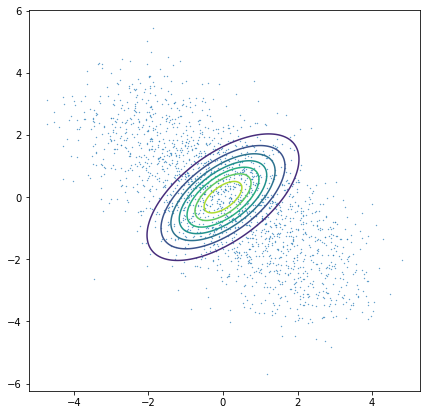

In [9]:
N    = 200
X    = np.linspace(-4, 4, N)
Y    = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))
rv   = multivariate_normal([0, 0], [[1., 0.6],[0.6, 1.]])
Z    = rv.pdf(pos)

plt.figure(figsize=(7,7))
plt.contour(X, Y, Z)
plt.scatter(acceptedPoints_np[0,:], acceptedPoints_np[1,:], s=.1)
plt.show()